# 0.0 - INTRO

## 0.1 - IMPORTS

In [2]:
import pandas as pd
import inflection as sc
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as ss
import datetime as dt
import time
import joblib
import os
from sys import getsizeof  # get the object's memory usage 
from random import sample

# scaling and encoding
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

# ml models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# feature selecion
from boruta import BorutaPy

#ipython functions
from IPython.core.display import HTML
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

In [3]:
time_ini = time.perf_counter()

## 0.2 - HELPER FUNCTIONS

In [4]:
def cross_validation_ts(model, training_df, model_name, kfold=5, verbose=False):
    """
    Cross Validation para Time Series (Prequential expanding).
    Retorna um DataFrame com todas as métricas calculadas por `ml_error`.
    """
    result_list = []

    for k in range(kfold, 0, -1):
        if verbose:
            print("K-fold nº =", k)
            
        # start and end date of validation dataset
        val_start_date = training_df['date'].max() - dt.timedelta(weeks=k * 6)
        val_end_date = val_start_date + dt.timedelta(weeks=6)
        
        # filtering
        train_cv = training_df.query('date < @val_start_date')
        val_cv = training_df.query('date >= @val_start_date & date <= @val_end_date')
        
        # training dataset
        X_train_cv = train_cv.drop(columns=["sales", "date"])
        y_train_cv = train_cv['sales']
        
        # validation dataset
        X_val_cv = val_cv.drop(columns=["sales", "date"])
        y_val_cv = val_cv['sales']

        # model training
        model.fit(X_train_cv, y_train_cv)
        
        # prediction
        y_hat_cv = model.predict(X_val_cv)
        
        # performance and append to result_list
        result_list += [ml_error(model_name, np.expm1(y_val_cv), np.expm1(y_hat_cv))]
    
    df_result = pd.concat(result_list)
    mean_cv = df_result.mean(axis=0).rename('mean').round(3).astype(str)
    std_cv = df_result.std(axis=0).rename('std').round(3).astype(str)
    
    # concat columns
    df_result = mean_cv + " (" + std_cv + ")"
    df_result = df_result.to_frame().T
    
    # insert the model's name
    df_result['Model Name'] = model_name
    
    return df_result


def mean_absolute_percentage_error(y, y_hat):
    """
    Retorna o Mean Absolute Percentage Error (MAPE)
    """
    return np.mean(np.abs(( y - y_hat) / y))


def root_mean_square_percentage_error(y, y_hat):
    """
    Retorna o Root Mean Square Percentage Error (RMSPE)
    """
    return np.sqrt(np.mean(np.square(( y - y_hat) / y)))


def mean_percentage_error(y, y_hat):
    """
    Retorna o Mean Percentage Error (MPE)
    Utilizado para visualizar o bias positivo ou negativo do modelo
    """
    return np.mean(( y - y_hat) / y)


def ml_error(model_name, y, y_hat):
    """
    Retorna um dataframe com 1 linha contendo as 3 métricas implementadas
    *É necessário converter y e y_hat para a inversa da transformação que foi aplicado em 5.3.2. 
    * Nesse projeto a inversa de np.log1p é np.expm1.
    """
    mae = mean_absolute_error(y, y_hat)
    mape = mean_absolute_percentage_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    rmspe = root_mean_square_percentage_error(y, y_hat)
    mpe = mean_percentage_error(y, y_hat)
    
    return pd.DataFrame({
        'Model Name': model_name, 
        'MAE': mae, 'MAPE': mape, 
        'RMSE': rmse, 'RMSPE': rmspe,
        'MPE': mpe}, 
        index=[0]
    )


def cramer_v(x, y):
    """ Método de Cramér's V
    Media a correlação entre duas váriaveis categóricas ou entre categórica e numérica
    Referência : https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    """
    confusion_matrix = pd.crosstab(x, y).values
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape

    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    # correção de bias
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3 - LOADING DATA

In [6]:
# https://www.kaggle.com/c/rossmann-store-sales/data
df_sales_raw = pd.read_csv("data/train.csv")
df_store_raw = pd.read_csv("data/store.csv")

In [7]:
df_sales_raw.query("Store == 1047").sample(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
368157,1047,3,2014-08-13,3676,472,1,0,0,1
612396,1047,1,2013-12-30,5921,646,1,0,0,1
458526,1047,6,2014-05-17,3230,381,1,0,0,0


In [8]:
df_store_raw.query("Store == 1047")

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1046,1047,a,a,3750.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


### merge

In [9]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")
df_raw.query("Store == 1047").sample(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
370962,1047,7,2014-08-10,0,0,0,0,0,0,a,a,3750.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
542151,1047,1,2014-03-03,0,0,0,1,0,0,a,a,3750.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
426191,1047,7,2014-06-15,0,0,0,0,0,0,a,a,3750.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


# 1.0 - DESCRIÇÃO DOS DADOS

In [20]:
df1 = df_raw.copy() # o prof recomendou sempre fazer uma cópia do df em cada nova etapa

## 1.1 - Rename Columns

In [21]:
cols_old = list(df1.columns)

snakecase = lambda x: sc.underscore(x)
df1.columns = map(snakecase, cols_old)

In [22]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 - Data Dimensions

In [23]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Cols: {}".format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 - Data Types

In [24]:
df1["date"] = pd.to_datetime(df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [25]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

> Há (em suma) 3 formas de tratar missing values (nas colunas):
> - Excluir a coluna;
> - Imputação por algoritmos de ML; ou
> - Pensar no negócio e Imputar com o que achar que é mais lógico. (Esse foi o método escolhido para esse treinamento para exercitar o lado de negócios)

## 1.5 - Fillout NA

> Entender (se possível) o pq de cada missing value e tratar da melhor forma possível.

`competition_distance`: Iremos assumir que os valores NA receberão uma distancia muito maior ao que é encontrado no dataset.Como o max dessa coluna é 75860, podemos atribuir 200000 aos valores NA, indicando que os competidores estão extremamente longes.

In [26]:
df1['competition_distance'].max()

75860.0

In [27]:
input_above_max = lambda x: 200000.0 if math.isnan(x) else x

df1['competition_distance'] = df1['competition_distance'].apply(
    input_above_max)

---
`competition_open_since[_month/_year]`: Saber a quanto tempo um competidor mais proximo está aberto será importante para a fase de feature engineering, pois teoricamente as vendas tendem a cair quando um novo competidor abre uma loja proxima e tendem a se normalizar depois de um tempo.
A _assumption_ que optamos para tratar os dados faltantes é colocar a data da venda como sendo a data dessa coluna tbm, pois assim o tempo desde que a loja competidora foi aberta será 0; Talvez seja necessário alterar essa afirmação nas proximas iterações do CRISP.


In [28]:
input_date_month_if_na = lambda x: x['date'].month if math.isnan(x[
    'competition_open_since_month']) else x['competition_open_since_month']
df1['competition_open_since_month'] = df1.apply(input_date_month_if_na, axis=1)

input_date_year_if_na = lambda x: x['date'].year if math.isnan(x[
    'competition_open_since_year']) else x['competition_open_since_year']
df1['competition_open_since_year'] = df1.apply(input_date_year_if_na, axis=1)

`promo2_since[_week/_year]`: Quando a loja não está participando da promo 2, que é uma continuaçao de alguma promoção, então essas duas colunas serão NA.
    Logo podemos fazer como acima e utilizar a coluna `date` para que no feature engineering essa distancia seja 0.

In [29]:
input_date_week_if_na = lambda x: x['date'].week if math.isnan(x[
    'promo2_since_week']) else x['promo2_since_week']
df1['promo2_since_week'] = df1.apply(input_date_week_if_na, axis=1)

input_date_year_if_na = lambda x: x['date'].year if math.isnan(x[
    'promo2_since_year']) else x['promo2_since_year']
df1['promo2_since_year'] = df1.apply(input_date_year_if_na, axis=1)

`promo_interval`: A estratégia que iremos utilizar aqui é imputar com 0 onde for NA. Além disso outras duas colunas serão criadas: `month_map` que recebera o mês de date como mês em 3 letras em inglês; `is_promo` (referente à promo2) que será 0 se promo_interval for 0 ou se mês não estiver contido na lista de meses em promo_interval e 1 caso contrário (se estiver em periodo de promoção extendida)

In [30]:
month_map = {
    1: 'Jan',
    2: 'Fev',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

is_promo_func = (lambda x: 0 if x['promo_interval'] == 0 else 1
                 if x['month_map'] in x['promo_interval'].split(',') else 0)
df1['is_promo'] = df1.apply(is_promo_func, axis=1)

In [31]:
df1.sample(3).T

,141786,275637,611745
store,182,1099,396
day_of_week,4,4,1
date,2015-03-26 00:00:00,2014-11-20 00:00:00,2013-12-30 00:00:00
sales,4694,7606,14564
customers,366,886,1541
open,1,1,1
promo,0,0,0
state_holiday,0,0,0
school_holiday,0,0,1
store_type,d,a,a


In [32]:
# verificação final: tudo ok (para o ciclo 1)
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 - Change types

> Fazendo algumas correções extras nos tipos dos dados 

In [33]:
df1['state_holiday'] = df1['state_holiday'].astype(str)

# esses valores estavam como float, porém devem ser int
df1['competition_open_since_month'] = df1[
    'competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 - Descriptive Statistical

Objetivos:
> Ganhar conhecimento de negócio

> Detectar alguns erros

__É necessário <u>dividir</u> o conjunto de dados em variáveis <u>categóricas</u> e <u>numéricas</u> para fazer as análises__

In [34]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

In [35]:
num_attributes.dtypes

store                             int64
day_of_week                       int64
sales                             int64
customers                         int64
open                              int64
promo                             int64
school_holiday                    int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
is_promo                          int64
dtype: object

### 1.7.1 - Numerical Attributes

In [36]:
# Gerando uma lista com todas as estatisticas de interesse
list_funcs = []

# Central tendency => mean, median
list_funcs += [np.mean, np.median]

# Dispersion => std, min, max, range, skew, kurtosis
list_funcs += [
    np.std, min, max, lambda x: x.max() - x.min(), lambda x: x.skew(),
    lambda x: x.kurtosis()
]

# iterando por cada estatistica e depois concatenando todas em um dataset
to_concat = [num_attributes.apply(func).to_frame().T for func in list_funcs]

m = pd.concat(to_concat).T.reset_index()
m.columns = [
    'attribute', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew',
    'kurtosis'
]

In [37]:
m

,attribute,mean,median,std,min,max,range,skew,kurtosis
0,store,558.429727,558.0,321.908493,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997390,1.0,7.0,6.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.924283,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411506,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485758,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,12547.646829,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,3.311085,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515591,1900.0,2015.0,115.0,-7.235657,124.071304


> Skew: concentração dos dados. se + está para esquerda e se - está para a direita

> kurtosis: Muito alto indica que possui um pico muito alto, caso contrário está mais esparso

<AxesSubplot:>

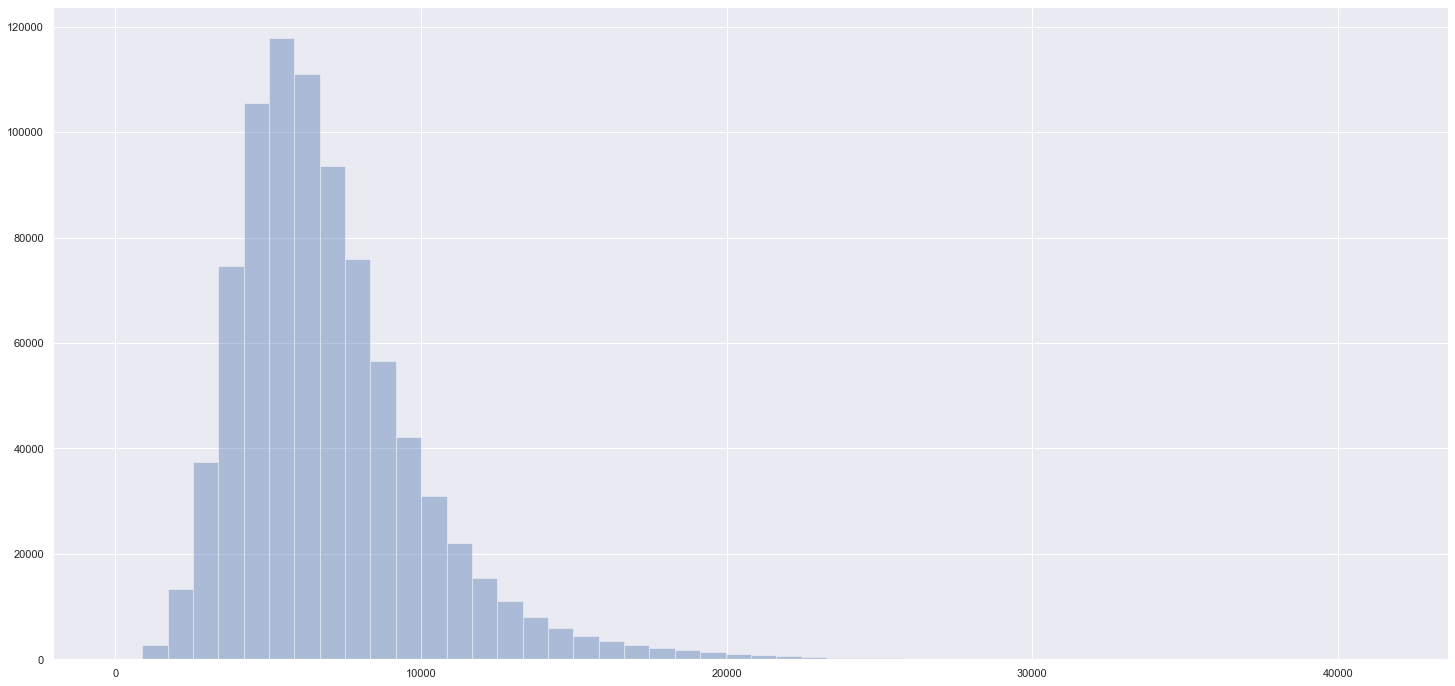

In [38]:
# Distribuição de vendas retirando os dias sem vendas (lojas fechadas)
sns.distplot(num_attributes[['sales']].query("sales != 0"), kde=False)

### 1.7.2 - Categorical Attributes

In [39]:
# quantidade de categorias em cada variavel
cat_attributes.apply(lambda x: x.unique().shape)

,state_holiday,store_type,assortment,promo_interval,month_map
0,4,4,3,4,12


In [40]:
# Existem muitos dias em que as lojas estavam fechadas, logo não tiveram vendas.
# Então é necessário tirar esses valores para o gráfico ficar mais visivel
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
aux1.sample(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
242267,335,4,2014-12-25,4146,726,1,0,c,1,b,a,90.0,12,2014,1,31,2013,"Jan,Apr,Jul,Oct",Dec,0
851033,1074,4,2013-05-30,6758,679,1,1,a,0,c,c,3330.0,10,2001,1,14,2011,"Jan,Apr,Jul,Oct",May,0


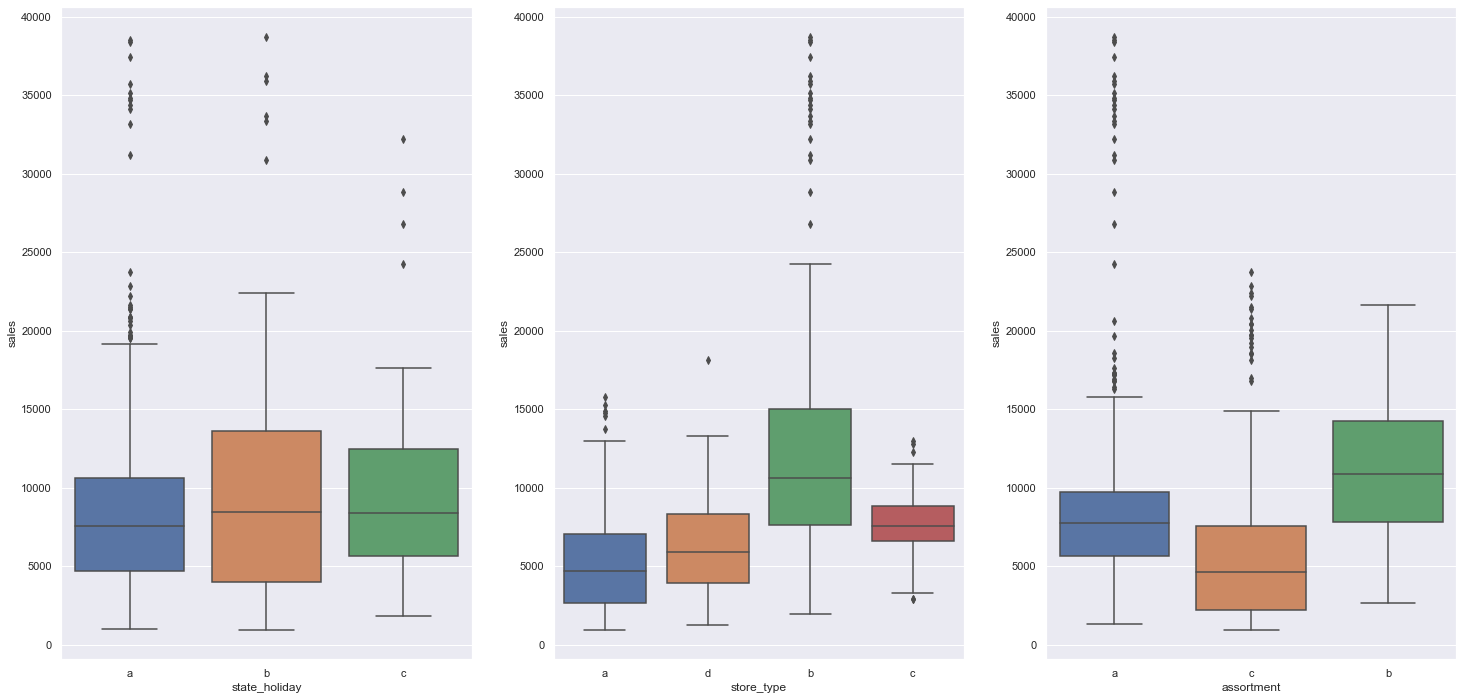

In [41]:
# note que y é var continua e x é var categorica

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)

sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)
plt.show()

__Observações__

- Feriados estaduais x sales:
    > - As medianas dos feriados `b` e `c` são semelhantes e maiores que `a`;
    > - O feriado `b` possui um range min-max maior que os demais;
    > - A distribuição do feriado `c` possui uma distorção para esquerda;
    > - O feriado `a` possui uma maior concentração das vendas que os demais;

- Tipo de loja x sales:
    > - O tipo `c` possui uma concentração maior que os demais;
    > - O tipo `b` possui o maior range min-max, uma distorção para a esquerda, ainda a maior numero de outliers e a maior mediana;

- assortment x sales:
    > - a categoria `a` possui mais outliers e maior concentração (maior kurtosis)
    > - O assortment `b` tem a maior mediana


# 2.0 - FEATURE ENGINEERING



In [42]:
df2 = df1.copy()

### 2.0.1 - Mapa Mental de Hipóteses

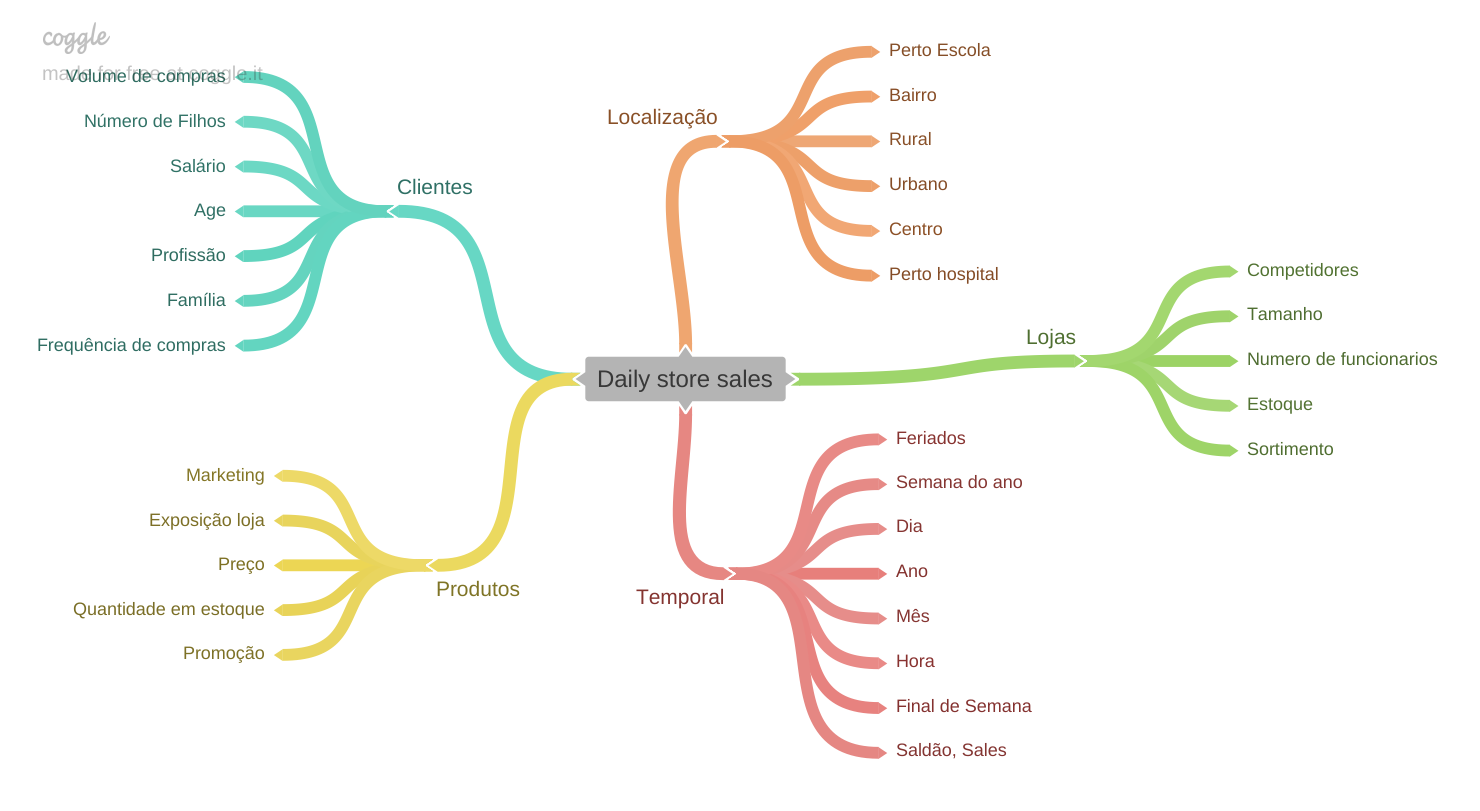

In [43]:
Image("img/Daily_store_sales.png", width=650)

## 2.1 - Criação das Hipóteses

**OBS:** 
> - Hipóteses são sempre achismos que devem ser aceitas ou rejeitadas através da EDA com os dados.
> - Sempre lembrar de que estamos avaliando correlação e não causalidade (ou seja: cada hipótese validada é apenas uma dentre varias que impactam na variavel resposta)

### 2.1.1 - Hipotese LOJA

1. Lojas com maior quadro de funcinarios deveriam vender mais. <sub>(num de func não disponivel nesse dataset)</sub>
2. Lojas com maior capacidade de estoque deveriam vender mais. <sub>(tam estoque não disp nesse dataset)</sub>
3. Lojas com maior porte deveriam vender mais. <sub>(tam da loja não disponivel)</sub>
4. Lojas com menor porte deveriam vender menos.
5. Lojas com competidores mais proximos deveriam vender menos. <sub>(infos de competidores estão no dataset)</sub>
6. Lojas com competidores à mais tempo deveriam vender mais. <sub>(infos de competidores estão no dataset)</sub>
7. Lojas com maior sortimento deveriam vender mais. <sub>(dados de sortimento estão contidos no dataset)</sub>

### 2.1.2 - Hipotese PRODUTO

1. Lojas que investem mais em marketing deveriam vender mais.
2. Lojas expoem mais os produtos nas vitrines deveriam vender mais.
3. Lojas que tem preços menores nos produtos deveriam vender mais.
5. Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.
6. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas com promoções ativas por mais tempo deveriam vender mais. 


### 2.1.3 - Hipotese TEMPO

1. Lojas abertas durante o feriado de natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.


## 2.2 - Lista final de Hipóteses

**Para priorizar hipoteses:** Selecionar as Hip que temos os dados necessarios nesse momento. Nas proximas iterações do CRISP pode ser que precisamos buscar mais por fora.

1. Lojas com maior sortimento deveriam vender mais.
2. Lojas com competidores mais proximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vender mais.

4. Lojas com mais dias de promoção deveriam vender mais.
5. Lojas com mais promoções consecutivas deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais. 

7. Lojas abertas durante o feriado de natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 - Feature Engineering

In [44]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
def combine_year_month(x):
    return dt.datetime(year=x['competition_open_since_year'],
                       month=x['competition_open_since_month'],
                       day=1)


df2['competition_since'] = df2.apply(combine_year_month, axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /
                                 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: dt.datetime.strptime(
    x + '-1', '%Y-%W-%w') - dt.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /
                          7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
map_state_holiday = lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day'
df2['state_holiday'] = df2['state_holiday'].apply(map_state_holiday)

# 3.0 - FILTRAGEM DE VARIÁVEIS



In [45]:
df3 = df2.copy()

In [46]:
df3.shape, df3.columns

((1017209, 29),
 Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
        'state_holiday', 'school_holiday', 'store_type', 'assortment',
        'competition_distance', 'competition_open_since_month',
        'competition_open_since_year', 'promo2', 'promo2_since_week',
        'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
        'month', 'day', 'week_of_year', 'year_week', 'competition_since',
        'competition_time_month', 'promo_since', 'promo_time_week'],
       dtype='object'))

**Obs**:
- Não é possível utilizar a feature `customers` diretamente, pois, não temos uma previsão de quantos clientes teremos daqui 6 semanas (teria que fazer um projeto separado para prever isso)
- Feature `open` não é importante, pois quando está fechado não vende nada e quando está aberto tem vendas, logo não tem nenhum aprendizado para extrair aqui e podemos excluir todas as linhas onde `open` == 0 e `sales` != 0
- 

## 3.1 - Filtragem das linhas

In [47]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 - Seleção das colunas



In [48]:
# coluna `open` sobrou apenas open==1, logo podemos exclui-la.
# Dropar colunas que foram usadas para derivar variaveis no processo de feature engineering
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [49]:
df3.shape  # retirou mais de 172k linhas e as 4 colunas

(844338, 25)

# 4.0 - ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

In [50]:
df4 = df3.copy()

In [51]:
num_attributes_df4 = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes_df4 = df4.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 - Análise Univariada 

### 4.1.1 - Response variable

<AxesSubplot:xlabel='sales'>

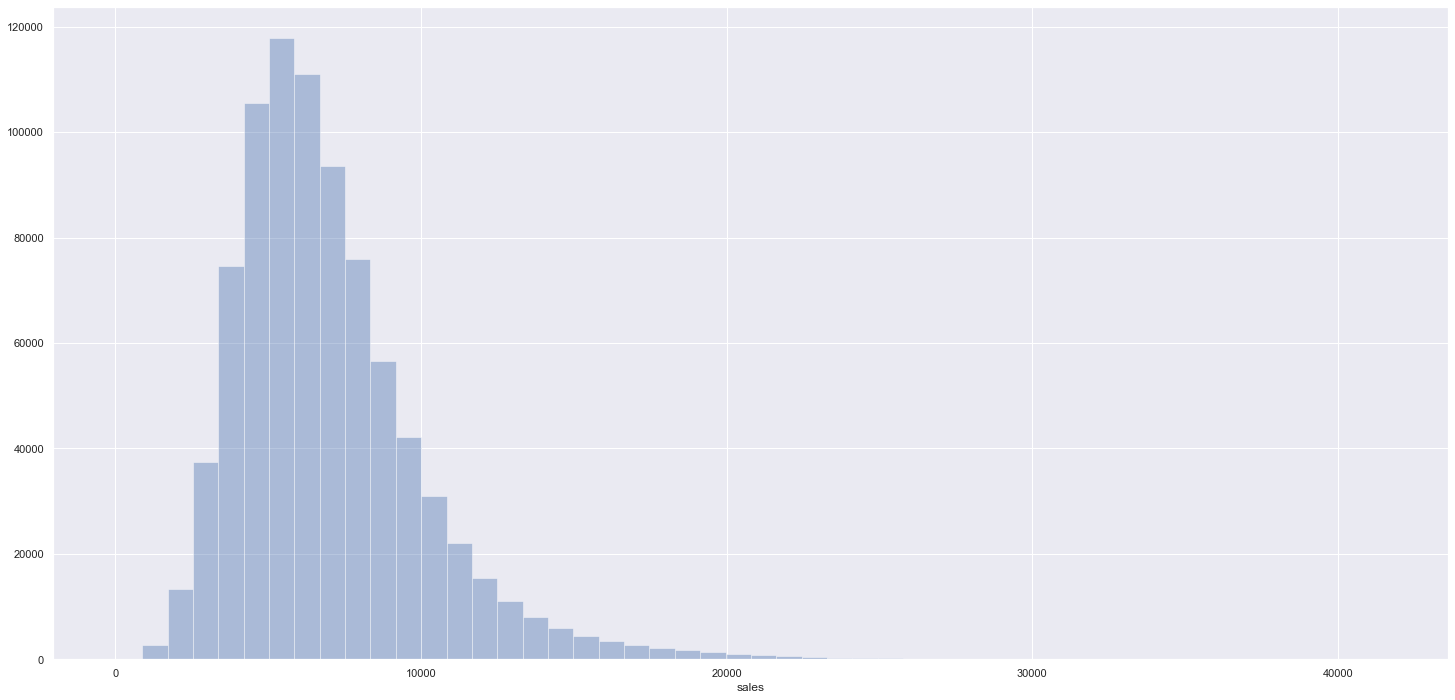

In [52]:
sns.distplot(df4['sales'], kde=False)

**Obs**:
- Tem formato de sino;
- Tem uma curtose
- Tem umas skew mais pra esquerda (positiva)
- Não está centrada
- Portanto está proxima de uma Normal, porém não é uma Normal
- Para aproximar mais da Normal, podemos fazer transformações, como aplicar log `(np.log1p(df4['sales']))` ou outras (pesquisar) que depende do conhecimento do negócio

**Quanto mais proximo da Normal a var resposta for, melhor o algoritmo vai performar**

### 4.1.2 - Numerical variable

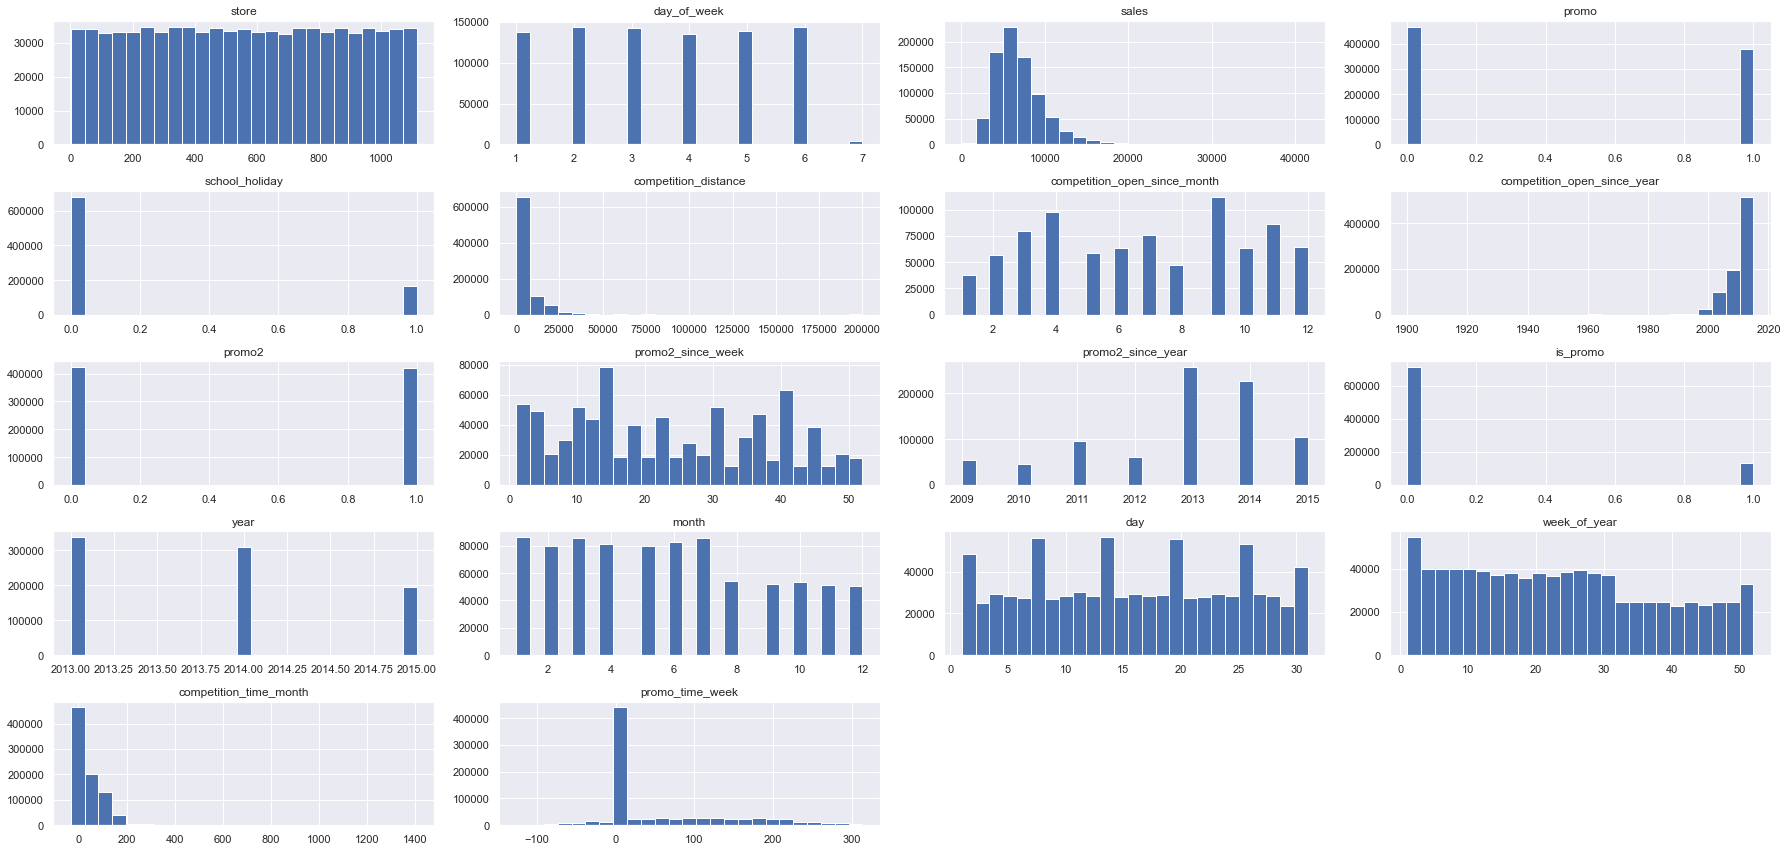

In [53]:
num_attributes_df4.hist(bins=25)
plt.tight_layout()

#### **Algumas análises (minhas)**:

- `store`: A quantidade de registros (compras) por loja está quase uniforme, com poucas variações (pode ser melhor explorado).
- `day_of_week`: Aparentemente todos os dias da semana possuem qt de registros muito proximas, exceto domingo que possui bem menos (3593 registros).
- `sales`: possui um skew positivo (p/ esquerda). Média de 6955.96 e mediana de 6369.00 (mediana menor que média, por isso a skew positiva).
- `promo`: ~56% dos registros __não__ estão em periodo de promoção, o restante com promoção.
- `school_holiday`: ~80% dos registro __não__ eram de dias em que as escolas estavam fechadas, o restante sim.
- `competition_distance`: A maioria dos competidores estão bem proximos.
- `competition_open_since_month`: Possui picos em Abril e Setembro.
- `competition_open_since_year`: Aparentemente a concorrencia está aumentando com o passar do tempo (o que é bem lógico).
- `promo2`: ~ Metade das promoções foram extendidas (promo2)
- `promo2_since_week`: Há um pico nas semanas 12-14 (páscoa?) e 40-42 (alguma explicação?)
- `promo2_since_year`: provavelmente 2015 possui menos registros pq a competição foi lançado na metade de 2015, então não tem como tirar muitas conclusões . Apenas que as promos começaram a ser extendidas em maior quantidade depois de 2013.
- `is_promo`: Aproximadamente 85% dos registro não estão em periodo de promoção extendida <u>(contraditório com variavel `promo2`)</u>
- `year`: Mesma observação sobre 2015 que fiz em promo2_since_year
- `month`: possui menos registros entre agosto e dezembro 
- `day`: Olhando para o histograma acima vemos uns picos em alguns grupos de dias, porém acho que está impreciso. Fazendo um count plot para cada dia, fica mais suave. Com maiores valores nos dia 11, 4, 27, 13 e 23 (nessa ordem) e menor no dia 1º de cada mês. 
- `week_of_year`: Maior numero de registros nas semanas: 26 (max), 12, 9 e 11. E menores em: 52(min), 40 e 44
- `competition_time_month`: maior quantidade de registros em 0 e 1. Negativo significa que o competidor ainda não abriu (vai abrir no futuro)
- `promo_time_week`: maiores em 0 e 52 semanas

### 4.1.3 - Categorical variable

In [54]:
cat_attributes_df4.sample()

,state_holiday,store_type,assortment,year_week
407554,regular_day,a,basic,2014-26


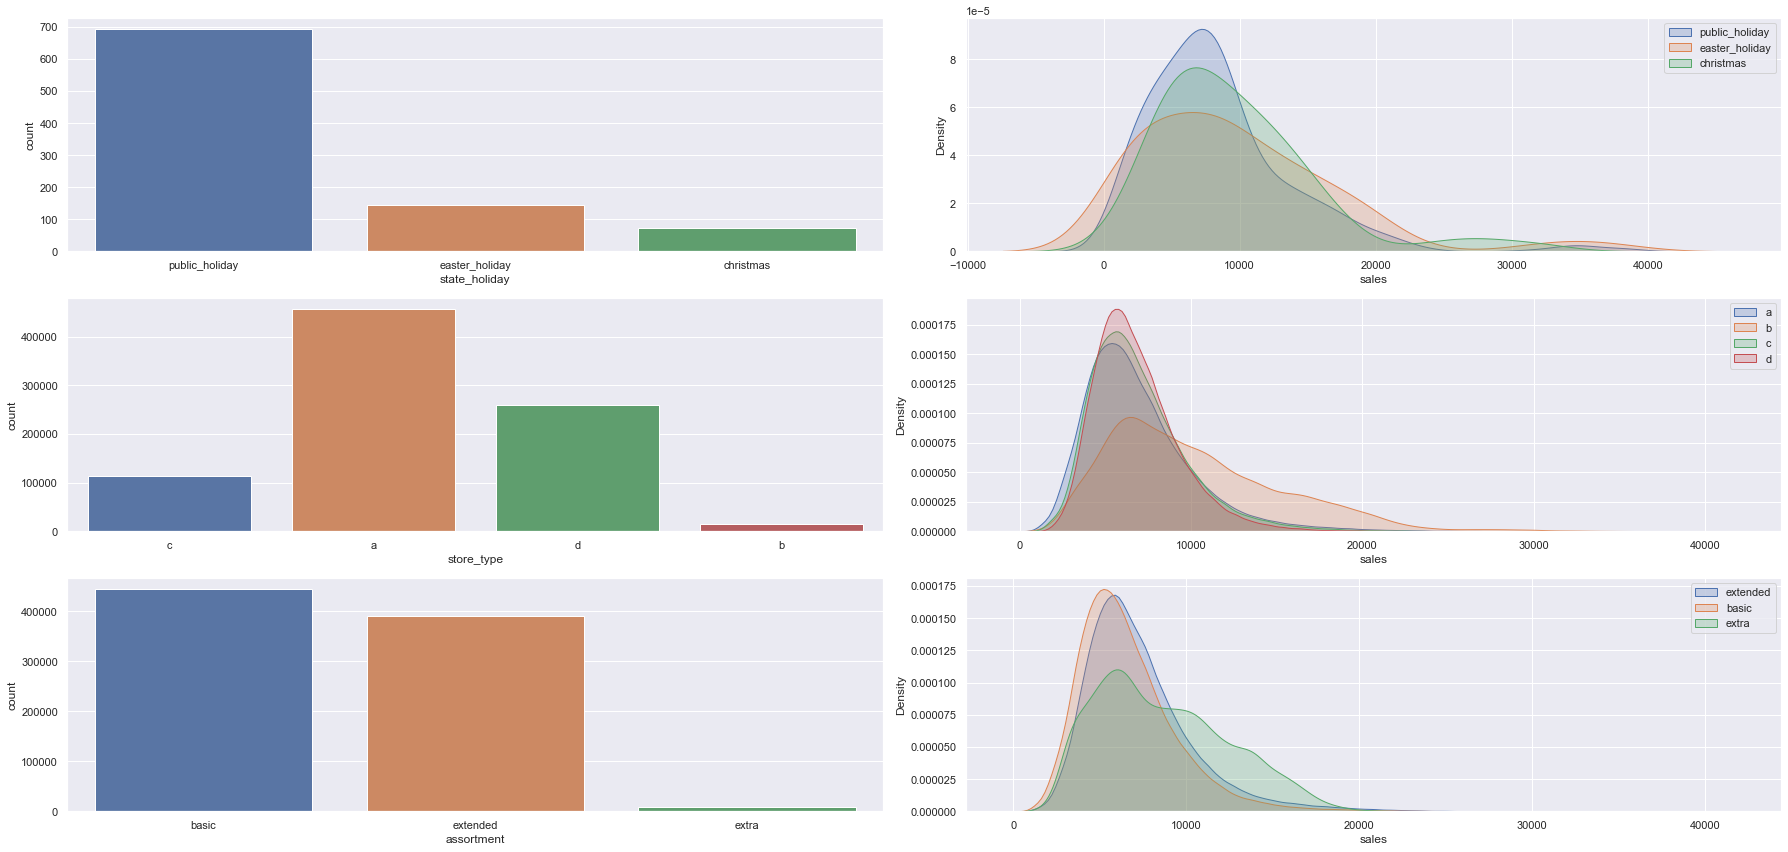

In [55]:
# state_holiday
aux4 = df4.query('state_holiday != "regular_day"')
plt.subplot(3, 2, 1)
sns.countplot(aux4['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(x='sales',
            data=aux4.query('state_holiday == "public_holiday"'),
            label='public_holiday',
            shade=True)
sns.kdeplot(x='sales',
            data=aux4.query('state_holiday == "easter_holiday"'),
            label='easter_holiday',
            shade=True)
sns.kdeplot(x='sales',
            data=aux4.query('state_holiday == "christmas"'),
            label='christmas',
            shade=True)
plt.legend()
plt.tight_layout()

#------------------------------
# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(x='sales',
            data=df4.query('store_type == "a"'),
            label='a',
            shade=True)
sns.kdeplot(x='sales',
            data=df4.query('store_type == "b"'),
            label='b',
            shade=True)
sns.kdeplot(x='sales',
            data=df4.query('store_type == "c"'),
            label='c',
            shade=True)
sns.kdeplot(x='sales',
            data=df4.query('store_type == "d"'),
            label='d',
            shade=True)
plt.legend()
plt.tight_layout()

#------------------------------
# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(x='sales',
            data=df4.query('assortment == "extended"'),
            label='extended',
            shade=True)
sns.kdeplot(x='sales',
            data=df4.query('assortment == "basic"'),
            label='basic',
            shade=True)
sns.kdeplot(x='sales',
            data=df4.query('assortment == "extra"'),
            label='extra',
            shade=True)
plt.legend()

plt.tight_layout()
plt.show()

#### **Algumas análises (minhas)**:

- `state_holiday`: TO DO 
- `store_type`: TO DO
- `assortment`: TO DO
- `year_week`: TO DO

## 4.2 - Análise Bivariada 

### Loja-H1. Lojas com maior sortimento deveriam vender mais
**FALSA**: Lojas com MAIOR SORTIMENTO vendem MENOS (considerando que `extra` significa mais sortimentos )

<AxesSubplot:xlabel='year_week'>

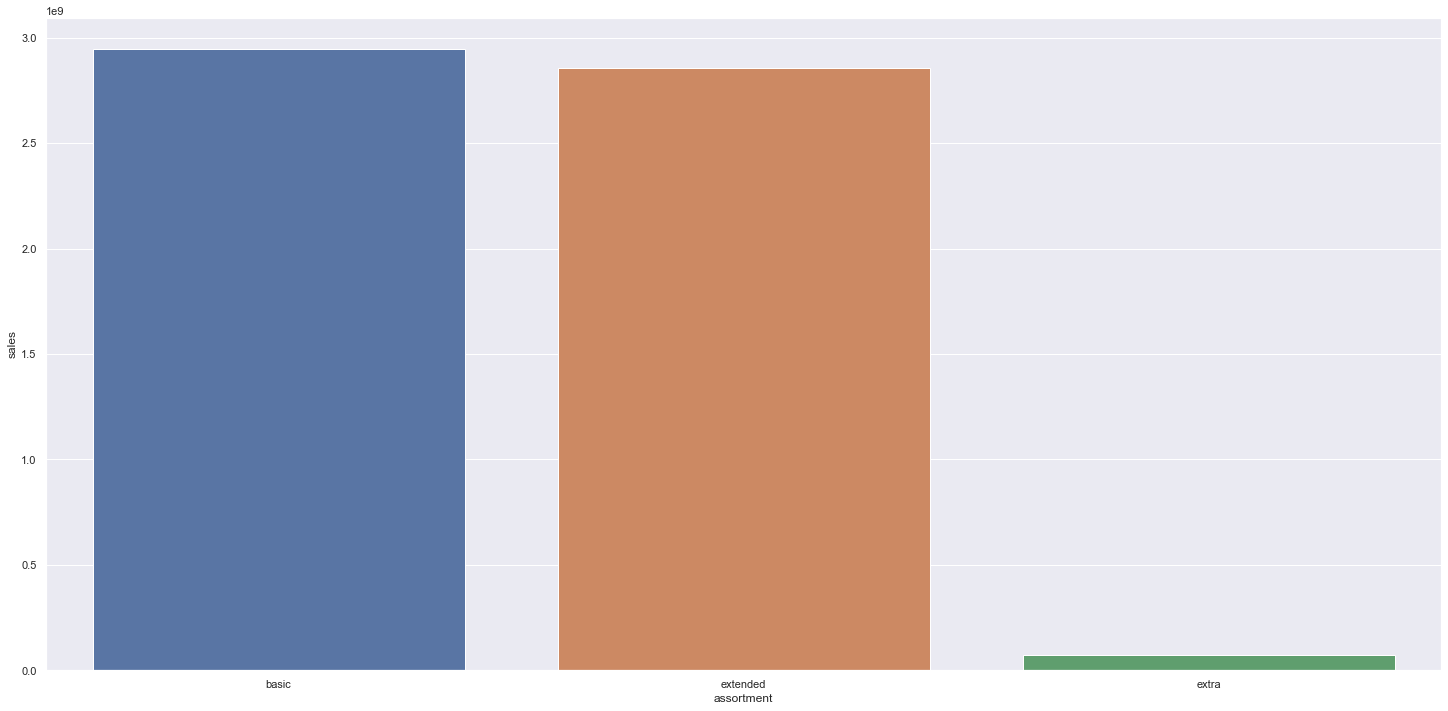

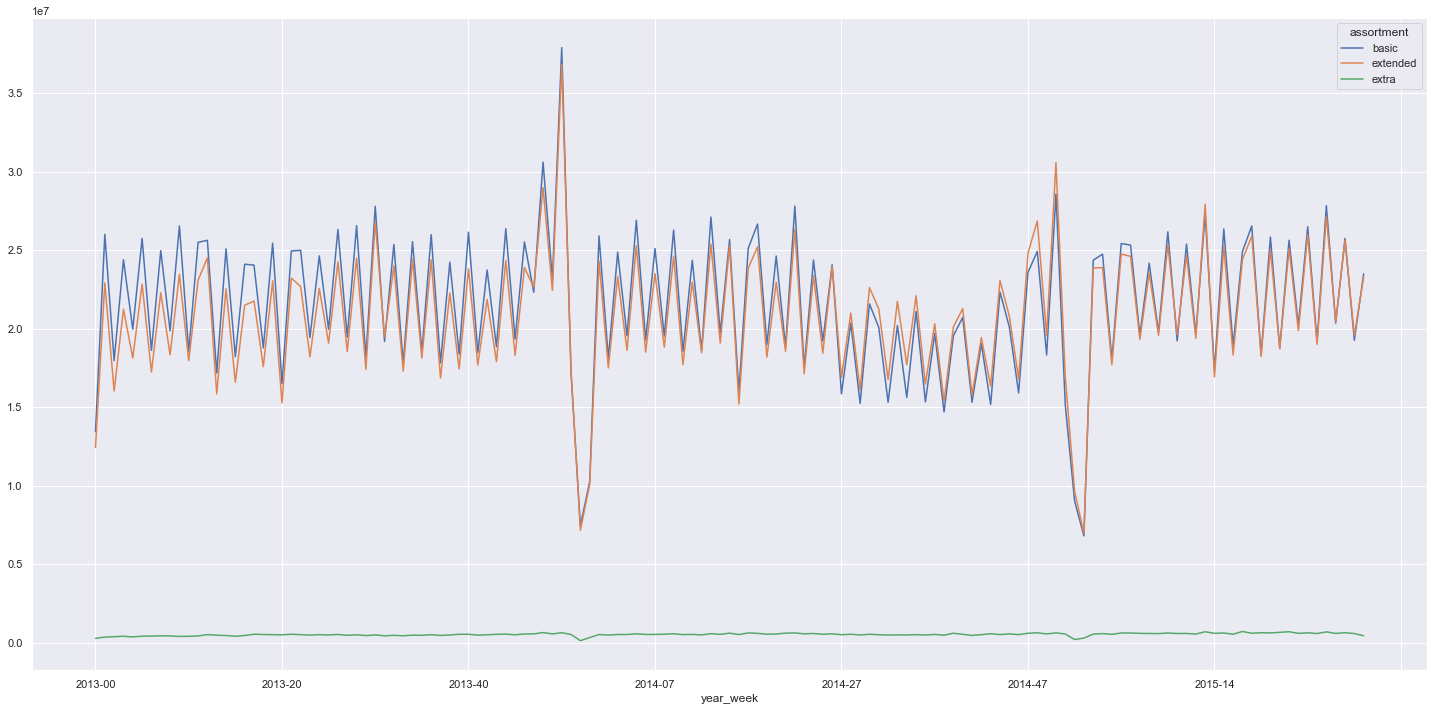

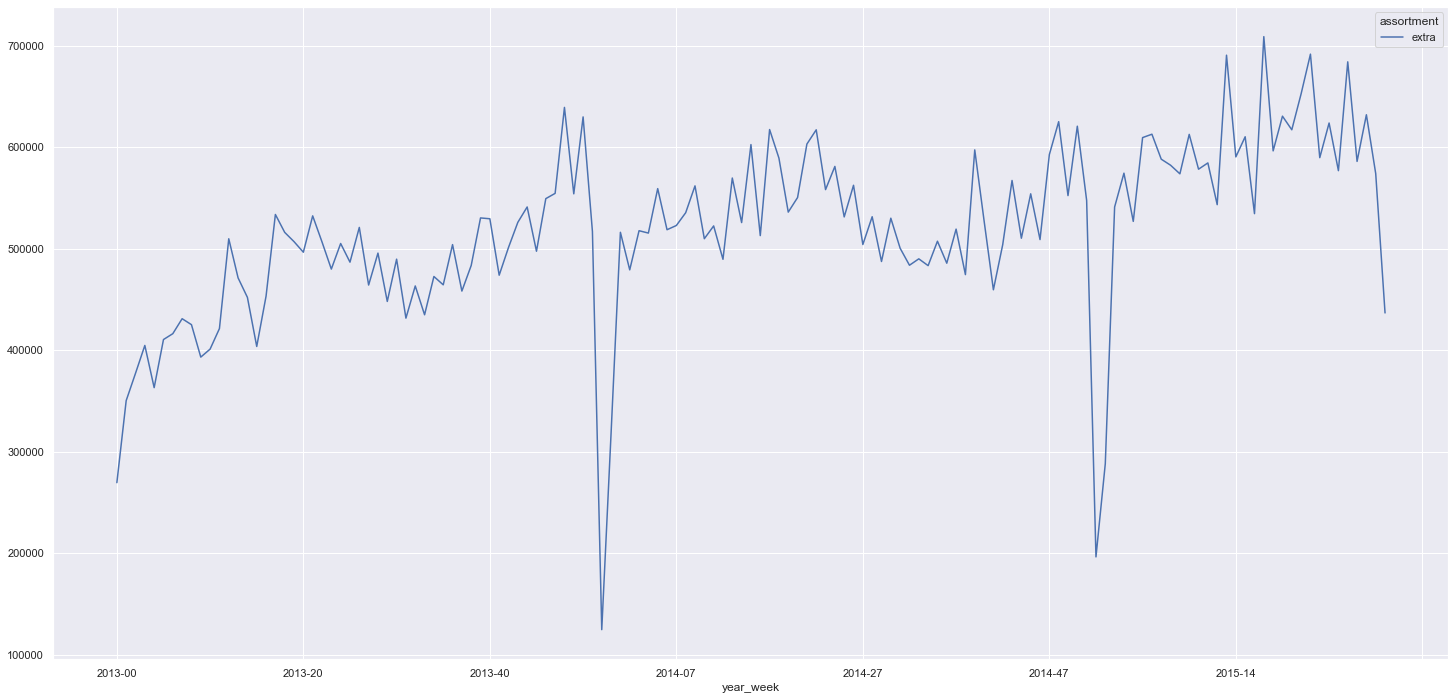

In [56]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment',
            'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### Loja-H2. Lojas com competidores mais proximos deveriam vender menos
**FALSA:** Lojas com COMPETIDORES MAIS PROXIMOS vendem MENOS (por análise simples, e considerando que -.23 é uma correlação negativa suficiente)

<AxesSubplot:>

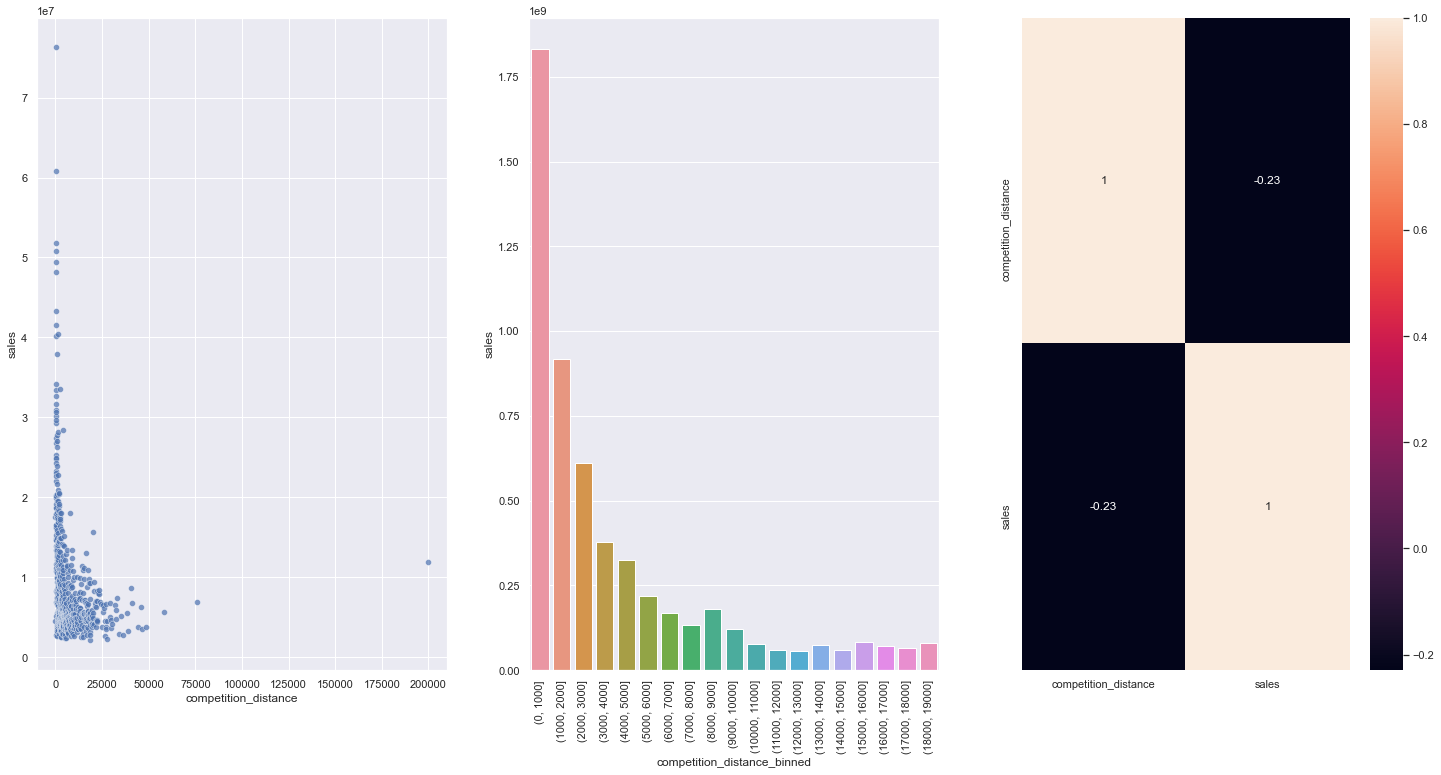

In [57]:
aux1 = df4[['competition_distance',
            'sales']].groupby(['competition_distance']).sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(
    x='competition_distance',
    y='sales',
    data=aux1,
    alpha=0.7,
)
# plt.xscale('log')

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],
                                             bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales'
             ]].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
# ref para os tipos de correlações: https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### Loja-H3. Lojas com competidores à mais tempo deveriam vender mais
**FALSA:** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

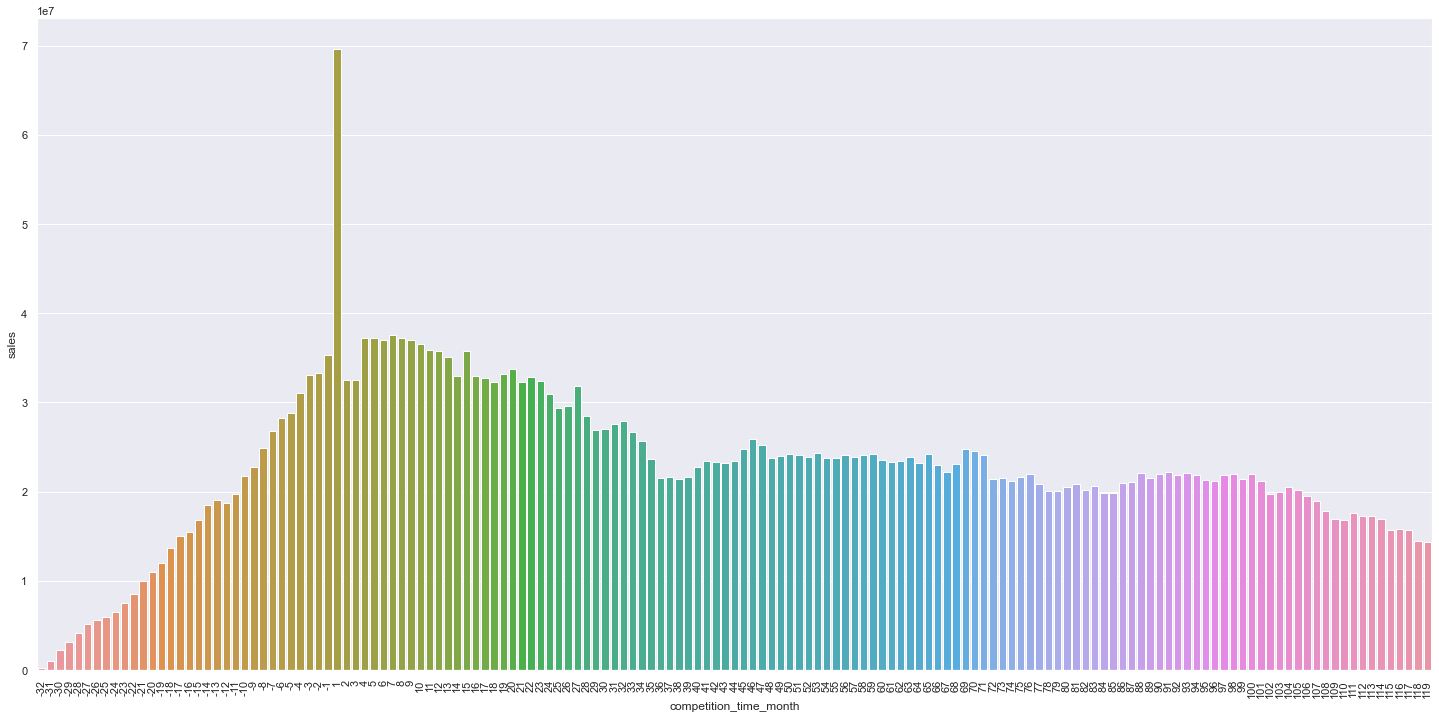

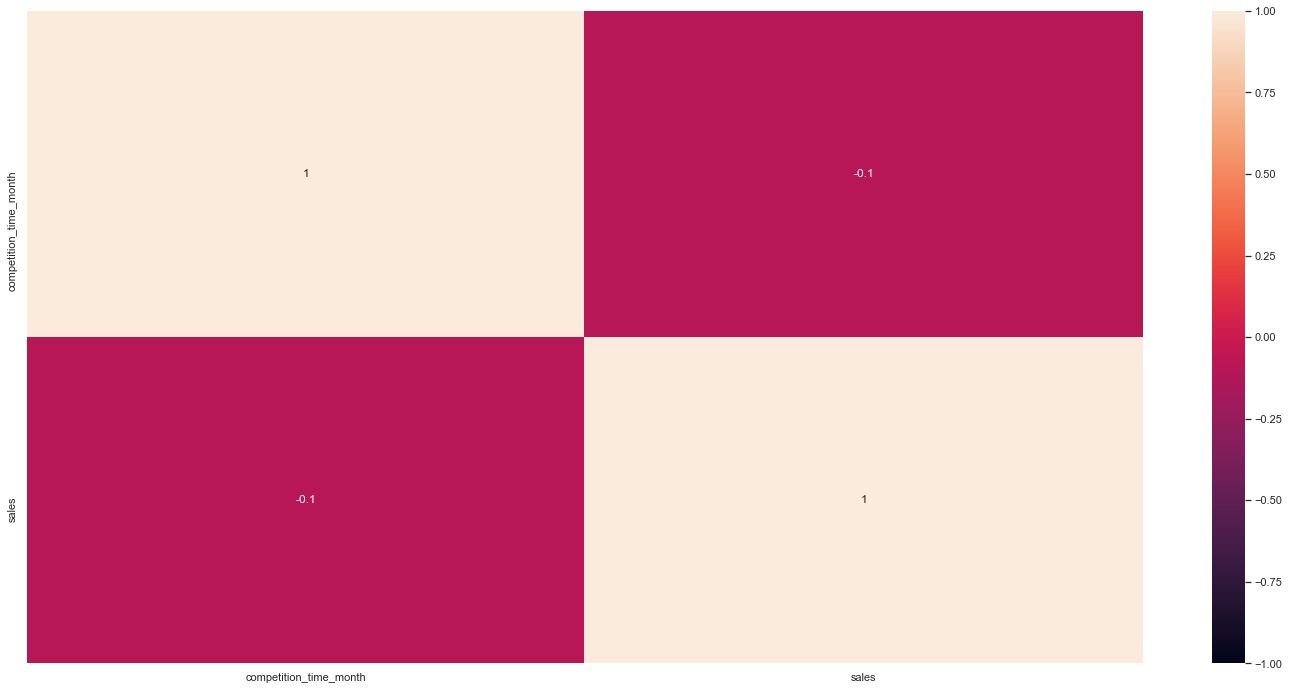

In [58]:
aux1 = df4[['competition_time_month',
            'sales']].groupby(['competition_time_month']).sum().reset_index()
aux2 = aux1.query('competition_time_month < 120 & competition_time_month != 0')
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.show()
#---
sns.heatmap(aux1.corr(method='pearson'), annot=True, vmin=-1)
plt.show()

### Loja-H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA**: Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS, depois de um certo periodo de promoção

In [59]:
# promo_time_week foi calculada como a diferença entre a data da compra - a data do inicio da promo 2 (entensão)
# promo_time_week negativo significa que está em periodo de promoção regular. Se positivo, então está no periodo de promo estendida

<AxesSubplot:>

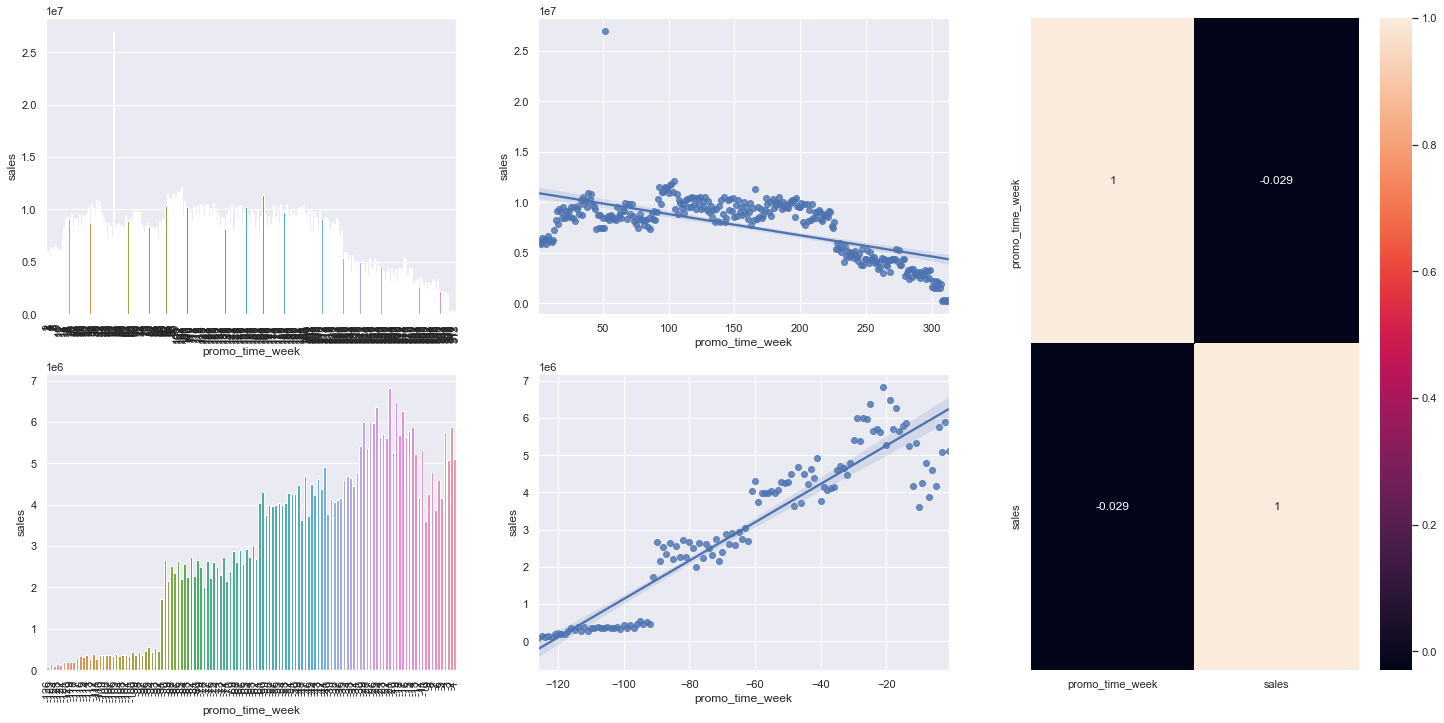

In [60]:
# Filtar esses ds auxiliares são apenas para a EDA, no modelo é utilizado todo o conjunto. Logo a correlação deve ser sobre todos os registros de promo_time_week

aux1 = df4[['promo_time_week',
            'sales']].groupby('promo_time_week').sum().reset_index()

# para ter mais liberdade para montar o grid de subplots
gd = GridSpec(2, 3)

plt.subplot(gd[0, 0])
aux2 = aux1.query('promo_time_week > 0')  # promo estendida
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(gd[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

#---
plt.subplot(gd[1, 0])
aux3 = aux1.query('promo_time_week < 0')  # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(gd[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

#---
plt.subplot(gd[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### ~~Loja-H5. Lojas com mais dias de promoção deveriam vender mais~~
**(Precisará de mais processamentos no dataset, então deixaremos para o proximo ciclo do CRISP)**

### Loja-H6. Lojas com mais promoções consecutivas deveriam vender mais
**FALSA**: Lojas com promoções consecutivas vendem MENOS

In [61]:
aux1 = df4[['promo', 'promo2',
            'sales']].groupby(['promo', 'promo2']).sum().reset_index()
aux1.sort_values('sales')

# result: Aparentemente não há vantagem em fazer a promo2

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


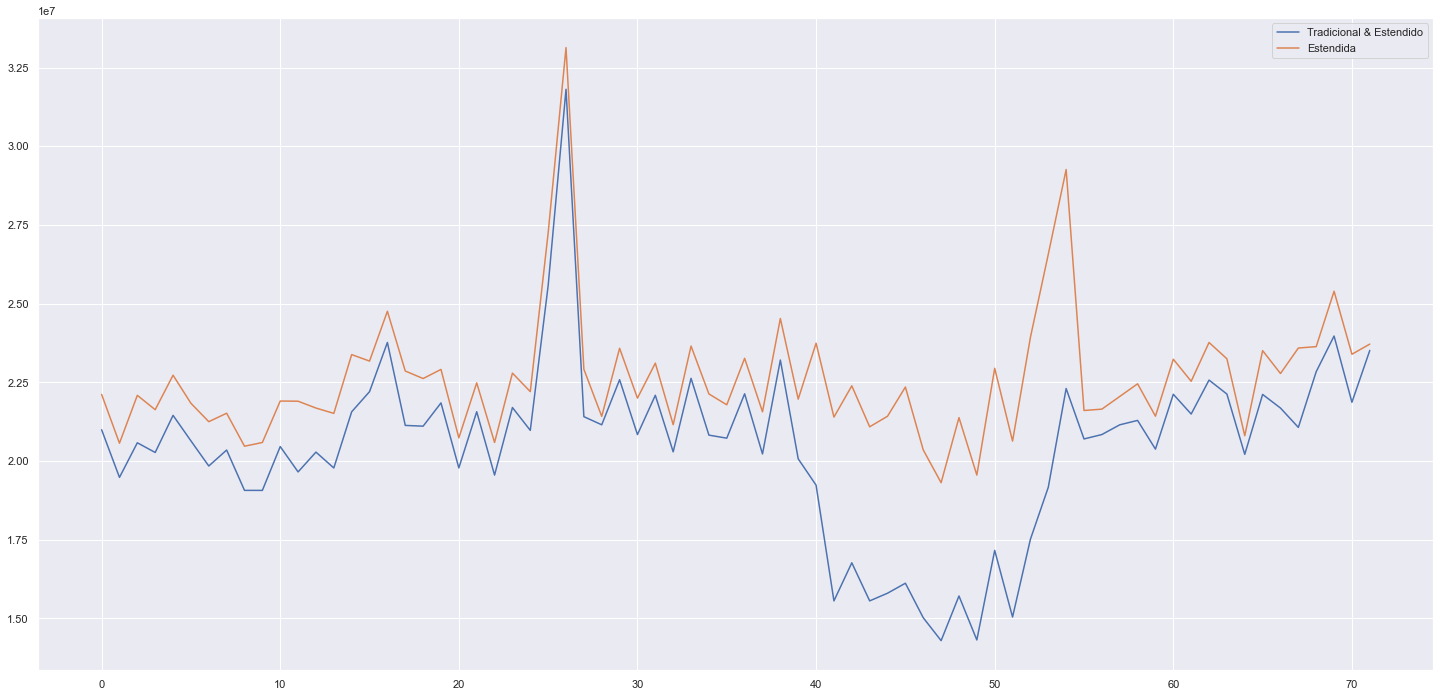

In [62]:
aux1 = df4.query('promo == 1 & promo2 == 1')[[
    'year_week', 'sales'
]].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4.query('promo == 1 & promo2 == 0')[[
    'year_week', 'sales'
]].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

plt.legend(labels=['Tradicional & Estendido', 'Estendida'])

# Result: Em geral o comportamento é igual dos dois gráficos, apenas possuem magnitudes diferentes

### Loja-H7. Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA**: Lojas abertas durante o feriado de natal vendem menos. (considerando valores absolutos de vendas isso é bem óbvio, pois há apenas 1 dia de natal)

<AxesSubplot:xlabel='year', ylabel='sales'>

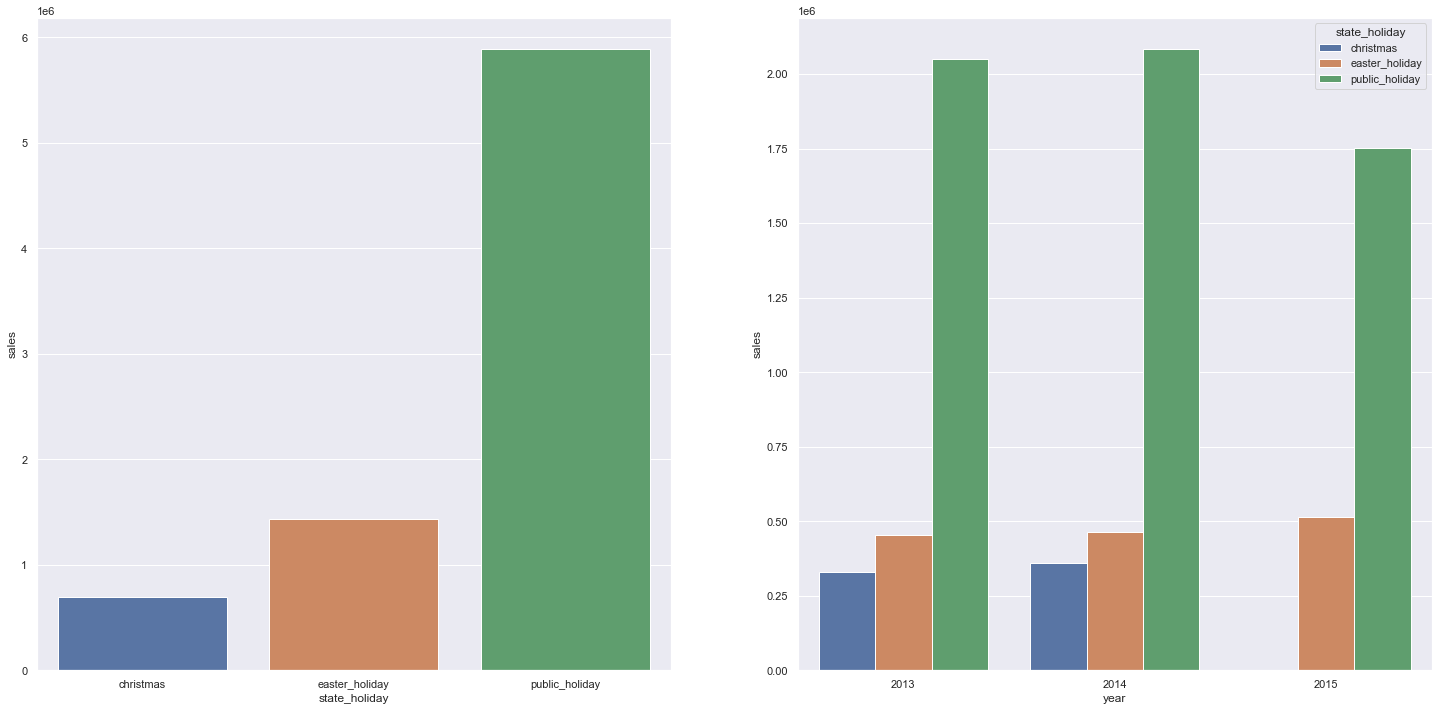

In [63]:
aux = df4.query('state_holiday != "regular_day"')

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday',
            'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday',
            'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', hue='state_holiday', y='sales', data=aux2)

### Loja-H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA**: Lojas vendem menos ao longo dos anos (considerando apenas 2013 e 2014, pois 2015 está incompleto)

<AxesSubplot:>

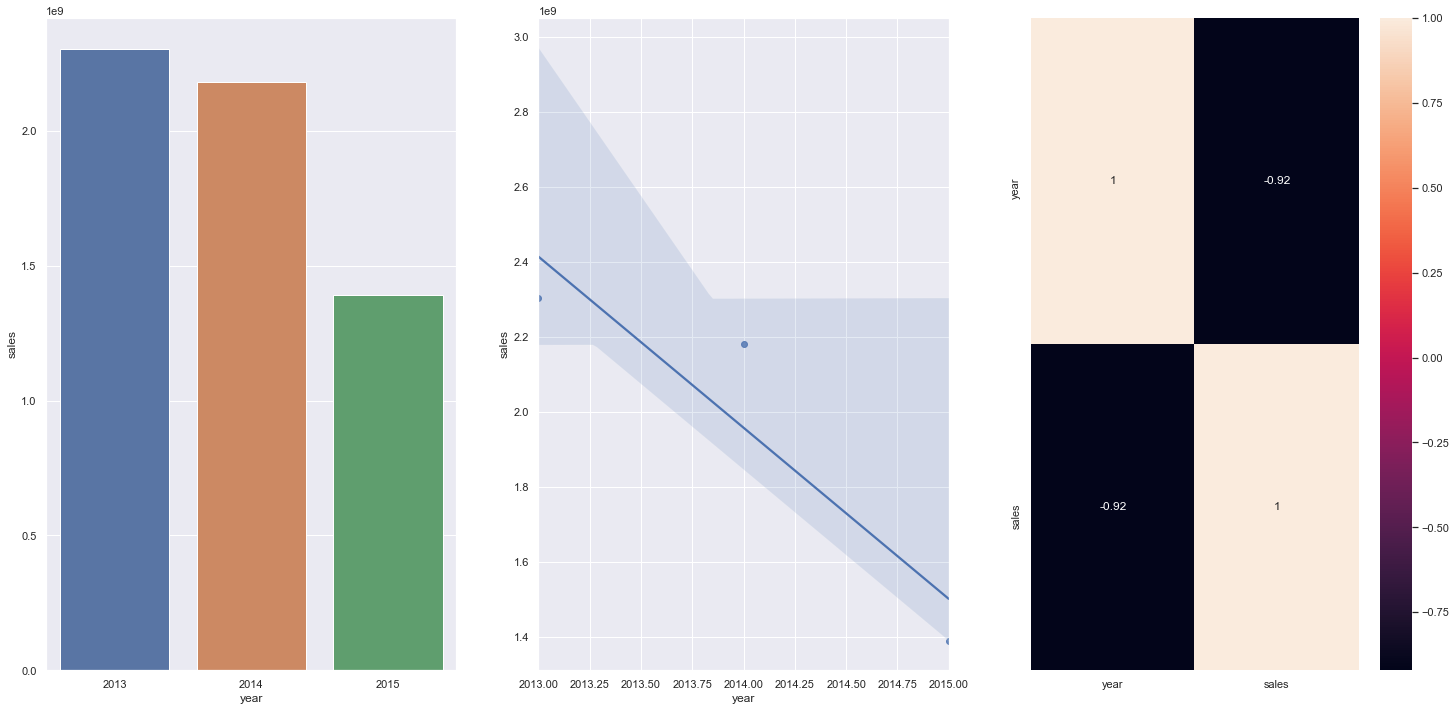

In [64]:
# Na vida real sempre pegar periodos fechados, pois periodos ainda não terminados como 2015 nesse ds, podem impactar nas análises

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### Loja-H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA**: Lojas vendem menos no segundo semestre do ano

<AxesSubplot:>

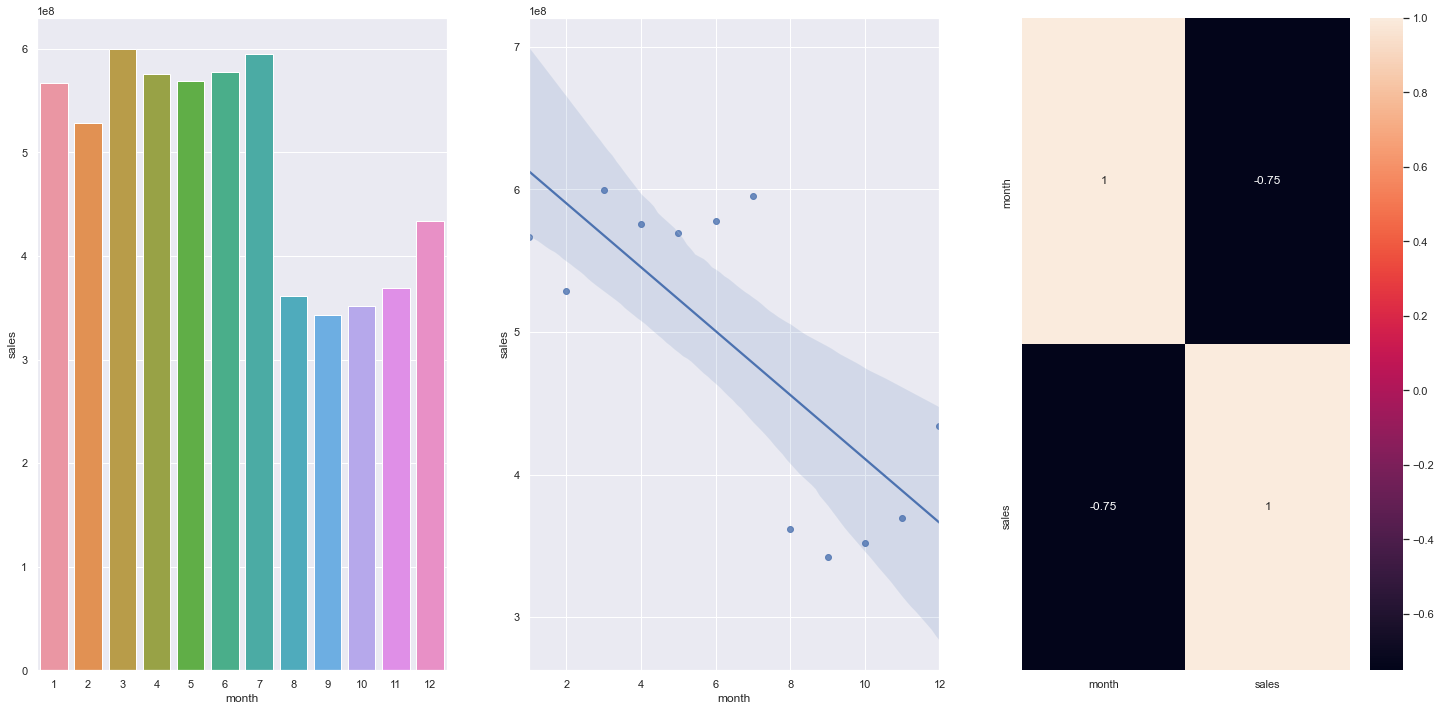

In [65]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### Loja-H10. lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA**: Lojas vendem mais depois do dia 10 de cada mês (O que é bem obvio, pois, vendas de 10 dias está em uma ordem diferente de vendas de 20 dias)

<AxesSubplot:xlabel='before_after', ylabel='sales'>

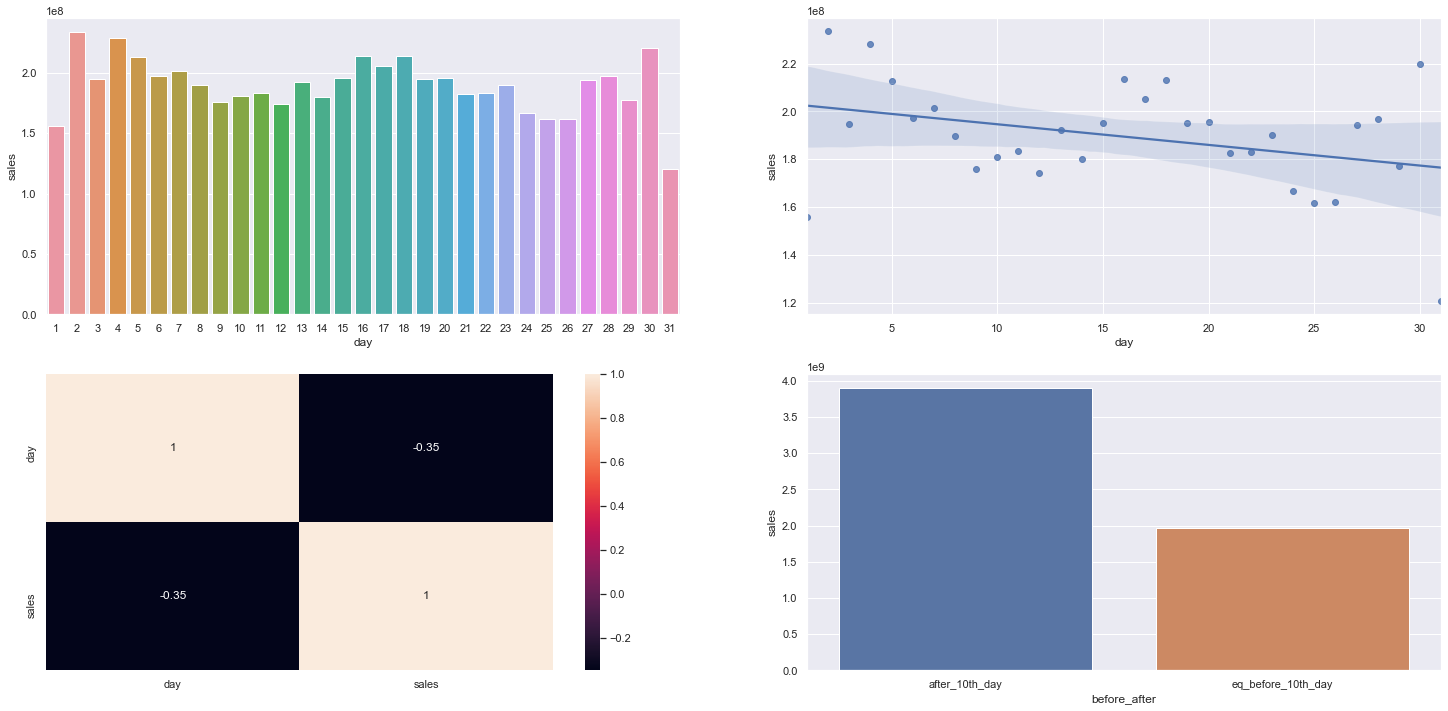

In [66]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'eq_before_10th_day'
                                         if x <= 10 else 'after_10th_day')
aux2 = aux1[['before_after',
             'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)

### Loja-H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA**: Lojas vendem menos nos finais de semana (porém a média e mediana de vendas do final de semana serem maiores)

<AxesSubplot:>

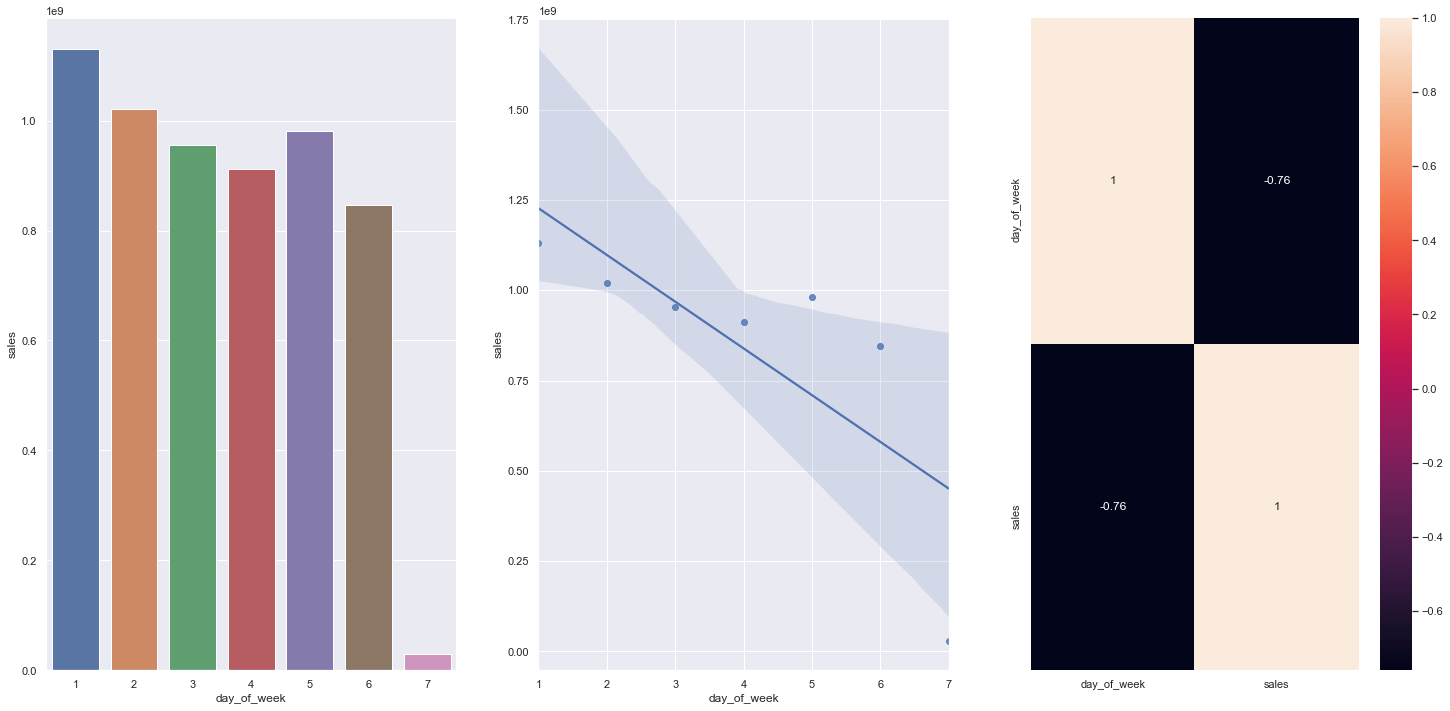

In [67]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#possivel questionamento: O horario de funcionamento nos finais de semana é reduzido?
#caso sim, essa pode ser uma justificativa para a quantidade de vendas menor que um dia da semana

#Outra questão: Sabemos que apenas algumas lojas ficam abertas no domingo,logo não seria melhor fazer uma análise separada para essas lojas?

### Loja-H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA**: Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto (Férias) 

<AxesSubplot:xlabel='month', ylabel='sales'>

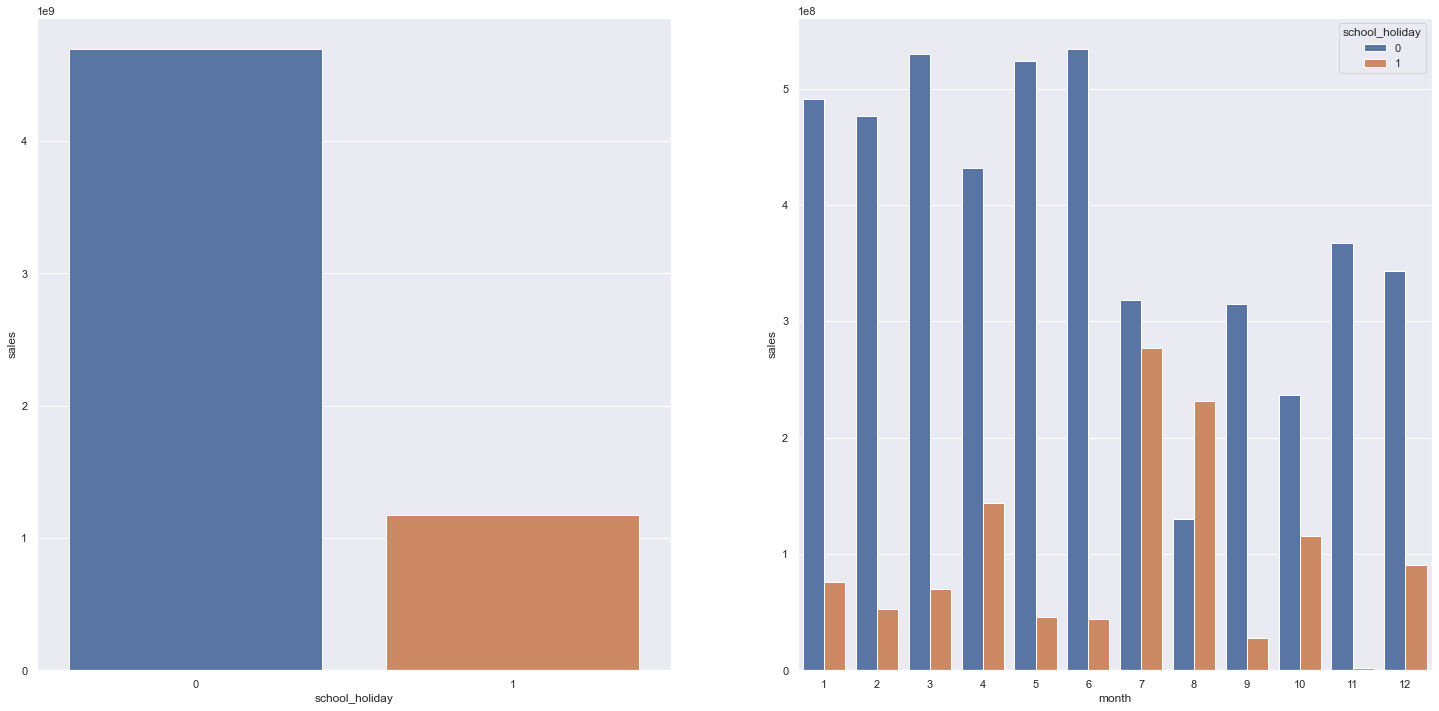

In [68]:
aux1 = df4[['school_holiday',
            'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday',
            'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(x='month', hue='school_holiday', y='sales', data=aux2)

### 4.2.1. Resumo das Hipoteses

In [69]:
from tabulate import tabulate

tab = [
    ['Hipoteses', 'Conclusao', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Media'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa'],
]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 - Análise Multivariada 

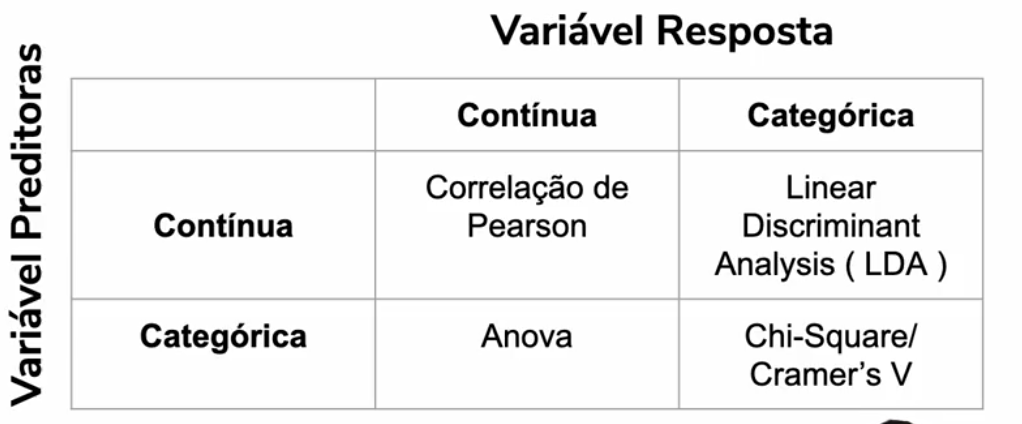
> **Quadro resumo correlações**

### 4.3.1 - Numerical Attributes

<AxesSubplot:>

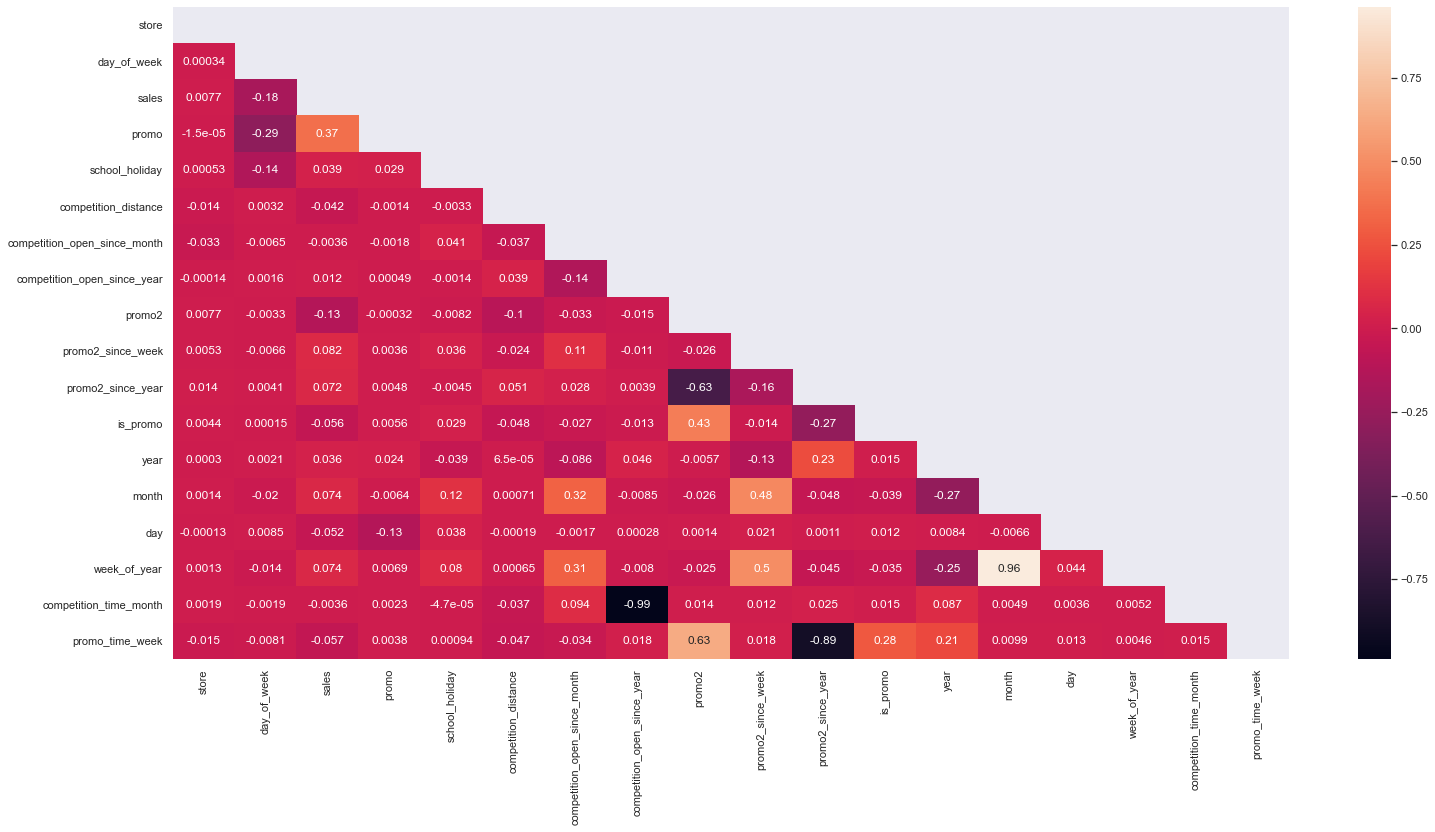

In [70]:
# corr de pearson é apenas para variaveis numéricas
correlation = num_attributes_df4.corr(method='pearson')

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(correlation, annot=True, mask=mask)

### 4.3.2 - Categorical Attributes

<AxesSubplot:>

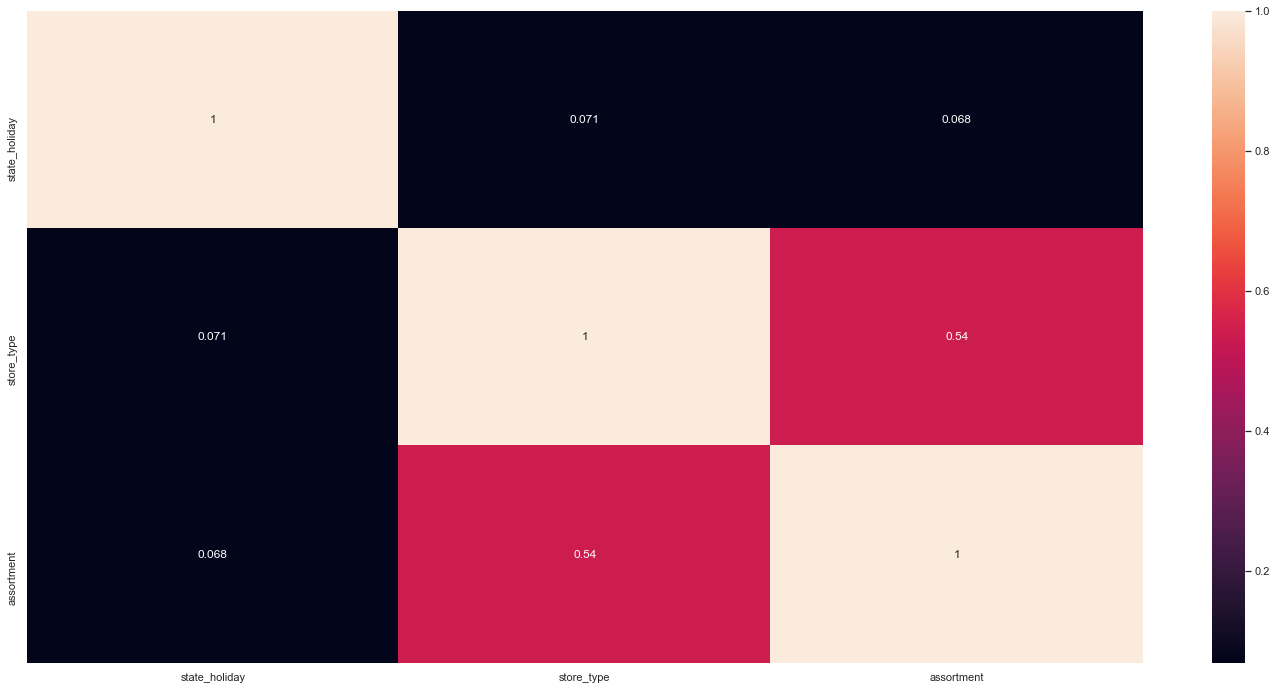

In [71]:
corr_dict = {}

cols = ['state_holiday', 'store_type', 'assortment']
# faz um combinação entre todas as colunas para gerar a matriz de correlação
for x in cols:
    corr_dict[x] = []
    for y in cols:
        corr_dict[x].append(
            cramer_v(cat_attributes_df4[x], cat_attributes_df4[y]))

df_corr = pd.DataFrame(corr_dict)
df_corr = df_corr.set_index(df_corr.columns)

sns.heatmap(df_corr, annot=True)

# 5.0 - PREPARAÇÃO DOS DADOS

> Consultar as distribuições na seção 4.1

In [72]:
df5 = df4.copy()

## 5.1 - Normalização

> OBS: Não existe nenhuma feature com distribuição normal ou próxima de uma normal, logo não iremos fazer normalização. 

## 5.2 - Rescaling

> De modo geral: Aplicar **Min-Max Scaler** quando a coluna não possuir muitos outliers e caso contrário aplicar **Robust Scaler** 

In [73]:
num_attributes_df4.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


#### 1.Separar as variaveis para o scaling:

In [74]:
vars_to_scaling = [
    'competition_distance',  # muitos outliers => Robust Scaler
    'competition_time_month',  # muitos outliers => Robust Scaler
    'promo_time_week',  # poucos outliers => MinMax Scaler
    'year',  # sem outliers => MinMax Scaler
]

#### 2. Gerar o boxplot de cada variável e analisar os outliers 

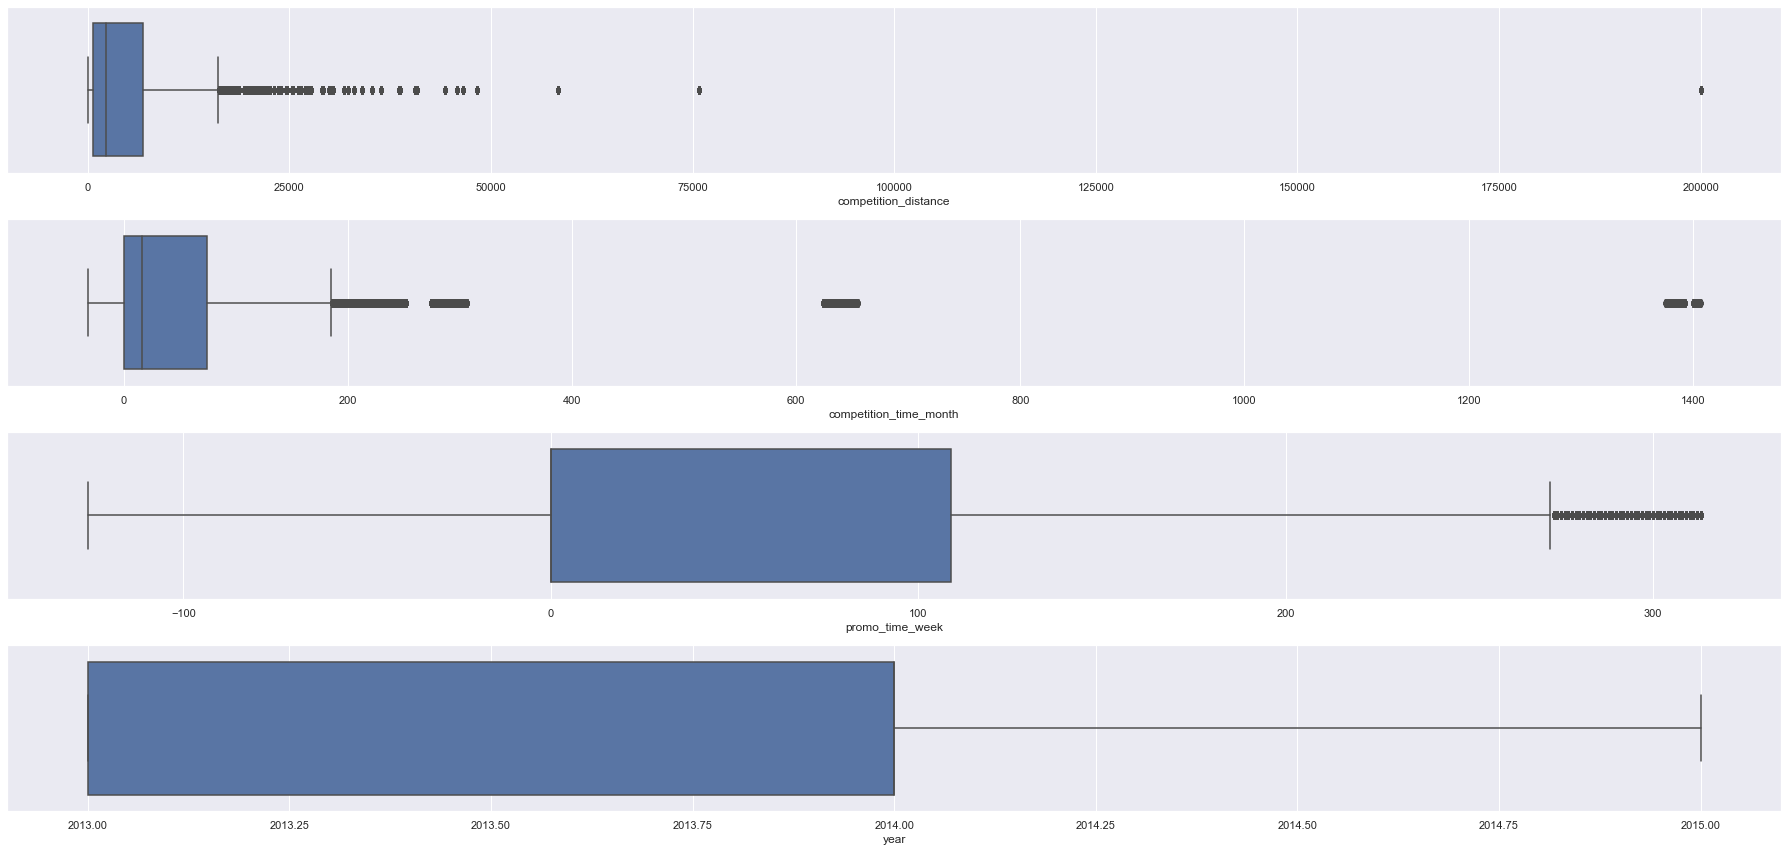

In [75]:
len_cols = len(vars_to_scaling)
for i, col in enumerate(vars_to_scaling, start=1):
    plt.subplot(len_cols, 1, i)
    sns.boxplot(x=col, data=df5[vars_to_scaling])
plt.tight_layout()

#### 3. Aplicar os scalers

In [76]:
# Robust scaler: possuem muitos outliers
rs = RobustScaler()
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
joblib.dump(rs, 'parameter/competition_distance_scaler.pkl.bz2')

df5['competition_time_month'] = rs.fit_transform(
    df5[['competition_time_month']].values)
joblib.dump(rs, 'parameter/competition_time_month_scaler.pkl.bz2')

# MinMax scaler: Não possuem outliers, ou possuem poucos
mms = MinMaxScaler()
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
joblib.dump(rs, 'parameter/promo_time_week_scaler.pkl.bz2')

df5['year'] = mms.fit_transform(df5[['year']].values)
joblib.dump(rs, 'parameter/year_scaler.pkl.bz2')

['parameter/year_scaler.pkl.bz2']

## 5.3 - Transformações

### 5.3.1 - Encoding

In [77]:
cat_attributes_df4.sample(5)

,state_holiday,store_type,assortment,year_week
368389,regular_day,c,basic,2014-32
466755,regular_day,d,extended,2014-18
778171,regular_day,d,extended,2013-30
382846,regular_day,a,basic,2014-30
701544,regular_day,d,basic,2013-40


In [78]:
#OBS: Rodar apenas uma vez

# state_holiday   -> é um estado momentâneo, logo Utilizar One Hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type -> Não possui ordem implicita (não é explicitado no dataset), logo utilizar Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
joblib.dump(le, 'parameter/store_type_encoding.pkl.bz2')

# assortment -> Possui uma ordem implicita (Consideramos que possui uma ordem na EDA, então manteremos dessa forma), logo utilizar Ordinal Encoding
assortment_dict = {
    'basic': 1,
    'extra': 2,
    'extended': 3
}  # Não deveria ser 1,3,2?
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [79]:
df5['assortment'].sample(5)

968057    1
877472    3
997625    1
711012    1
415879    3
Name: assortment, dtype: int64

### 5.3.2 - Response Variable Transformation

In [80]:
# Transformação logaritmica
df5['sales'] = np.log1p(
    df5['sales'])  # log1p= ln(x+1)  que é inverso de expm1 = exp(x)-1

<AxesSubplot:xlabel='sales - DEPOIS', ylabel='Density'>

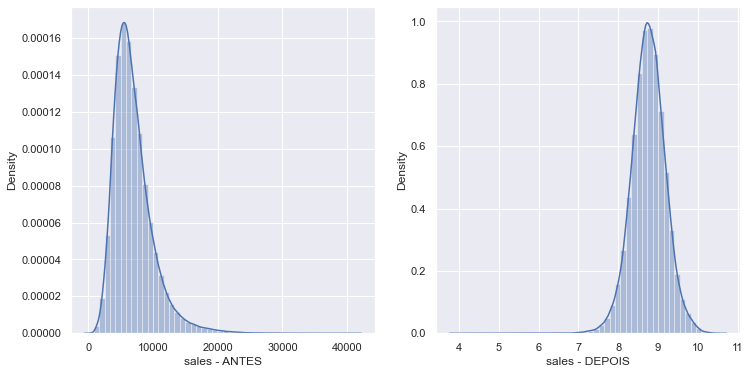

In [81]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

sns.distplot(df4['sales'], axlabel="sales - ANTES")

plt.subplot(1, 2, 2)
sns.distplot(df5['sales'], axlabel='sales - DEPOIS')

### 5.3.3 -Nature Transformation

In [82]:
# Variáveis que possuem uma natureza ciclica e que devem ser modificadas

def cyclic_transform(df, col, n):
    """
    Transforma a coluna `col` do dataframe `df` em uma forma cíclica com seno e cosseno. 
    `n` é a quantidade de níveis.
    """
    df[col + '_sin'] = np.sin(df[col].values * (2 * np.pi / n))
    df[col + '_cos'] = np.cos(df[col].values * (2 * np.pi / n))


# day_of_week
cyclic_transform(df5, 'day_of_week', 7)

# month
cyclic_transform(df5, 'month', 12)

# day
cyclic_transform(df5, 'day', 30)  # utilizando calendario comercial de 30 dias

# week_of_year
cyclic_transform(df5, 'week_of_year', 52)

### Deletar variaveis que foram utilizadas para derivar outras

In [72]:
cols_drop = [
    'week_of_year', 'day', 'month', 'day_of_week', 'promo_since',
    'competition_since', 'year_week'
]
df5 = df5.drop(cols_drop, axis=1)

# 6.0 - FEATURE SELECTION

In [227]:
try:
    df6 = df5.copy()
    df6.to_pickle(
        "data/df6.pkl"
    )  # persistindo df6 em disco para não ter que rodar todo o notebook posteriormente

except:
    df6 = joblib.load("data/df7.joblib.bz2")  #df6 == df7

## 6.1 - Split DataFrame into training and test dataset

> Para splitar dados de time series, é necessário separar em periodos sequenciais (ex: Antes de 01/06/2014 e Depois de 01/06/2014)

Aqui iremos utilizar as **6 últimas semanas como teste**, já que esse é o objetivo final

In [228]:
# obtendo data maxima e minima dos dados
min_max_date = df6[['store',
                    'date']].groupby('store').agg(['min',
                                                   'max']).drop_duplicates([
                                                       ('date', 'min'),
                                                       ('date', 'max')
                                                   ])
min_max_date

date           
             min        max
store                      
1     2013-01-02 2015-07-31
85    2013-01-01 2015-07-31
103   2013-07-05 2015-07-31
292   2013-01-02 2015-07-10
349   2013-04-12 2015-07-31
762   2013-01-19 2015-07-31
876   2013-01-02 2015-07-15

In [229]:
# subtraindo 6 semanas da data máxima
threshold_date = min_max_date.loc[:, ('date',
                                      'max')].max() - dt.timedelta(weeks=6)
threshold_date

Timestamp('2015-06-19 00:00:00')

In [230]:
# Training dataset
X_train = df6.query('date < @threshold_date')
y_train = X_train['sales']

# Test dataset
X_test = df6.query('date >= @threshold_date')
y_test = X_test['sales']

print("Training Min date={} | Max date={}".format(X_train['date'].min(),
                                                  X_train['date'].max()))
print("Test Min date={} | Max date={}".format(X_test['date'].min(),
                                              X_test['date'].max()))

Training Min date=2013-01-01 00:00:00 | Max date=2015-06-18 00:00:00
Test Min date=2015-06-19 00:00:00 | Max date=2015-07-31 00:00:00


## 6.2 - Boruta as a Feature Selector

> Obs: Demorou ~1.5 horas p/ rodar

In [12]:
#training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Se não foi possivel ler o arquivo pickle que está salva as colunas selecionadas, então executa o boruta
try:
    with open("cols_selected_boruta.pkl", "rb") as f_pkl:
        cols_selected_boruta = joblib.load(f_pkl)
        print("cols_selected_boruta carregado em memória.")
except:
    #define RandomForestRegressor
    rf = RandomForestRegressor(n_jobs=-1)

    print("Executando Boruta Feature Selector")

    #Define Boruta (rodar apenas uma vez. Resultado da seleção foi persistido em disco)
    boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
    boruta.fit(X_train_n, y_train_n)

cols_selected_boruta carregado em memória.


### 6.2.1 - Best features from Boruta

> Usaremos apenas as variaveis que o boruta sugeriu, mesmo que alguma esteja em contradição com nossas hipóteses com alta relevancia.\
> Adicionaremos apenas aquelas que são complementares, como month_sin e month_cos, etc.

> Para o proximo ciclo podemos adicionar essas outras variaveis que achamos importantes com as hipoteses.

In [8]:
cols_selected = boruta.support_.tolist(
)  # retorna um array com o indice das colunas selecionadas

# best features
X_train_fs = X_train.drop(['date', 'sales'],
                          axis=1)  # para retornar o df sem sales e date

cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list(
)  # pegando os nomes das colunas que o boruta selecionou

# not selected boruta (colunas que foram descartadas pelo boruta)
diff_cols = np.setdiff1d(
    X_train_fs.columns,
    cols_selected_boruta)  # para fazer a diferença entre os dois conjuntos
cols_not_selected_boruta = list(diff_cols)

NameError: name 'boruta' is not defined

### 6.2.2 - Colunas Selecionadas

In [ ]:
cols_selected_boruta

### 6.2.3 -  Colunas Rejeitadas

In [ ]:
cols_not_selected_boruta

### 6.2.4 - Manual Feature Selection
> Associar o conhecimento que temos dos dados com a resposta do Boruta

1. Olhar a tabela resumo de hipóteses e verificar as variáveis/hipoteses que possuem relevancia alta. 
2. Caso o Boruta esteja em contradição com essas informações, é papel do CD decidir o que fazer

In [ ]:
# columns to add manualy
cols_selected_boruta += ['month_sin', 'week_of_year_sin']

# columns to add (que haviamos retirado antes de passar pro boruta)
cols_selected_boruta += ['date', 'sales']

>Não foi possivel persistir o modelo de feature selection em disco, pois ficou com quase 8 GB alocado em memória. Então foi persistido apenas as colunas selecionadas e algumas outras selecionadas manualmente

In [ ]:
with open("parameter/cols_selected_boruta.pkl", "wb") as f_pkl:
    joblib.dump(cols_selected_boruta, f_pkl)

# 7.0 - MACHINE LEARNING MODELLING

> ATENÇÂO: Os resultados obtidos em 7.1, 7.2, 7.3, 7.4 e 7.5 não são os resultados reais.São apenas para comparar com average model.\
> **O resultado real é obtido através do CV nesse formato => mean+=std**

#### (Pre Loads)

In [224]:
try:
    df7 = df6.copy()
except:
    df7 = joblib.load("data/df7.joblib.bz2")

In [225]:
cols_selected_boruta_ = joblib.load("parameter/cols_selected_boruta.pkl")
print("cols_selected_boruta carregado em memória.")

cols_selected_boruta_extended = cols_selected_boruta_ + ["date", "sales"]
cols_selected_boruta = cols_selected_boruta_

cols_selected_boruta carregado em memória.


In [231]:
# df apenas com as features selecionadas (e tbm sem data e sales)
x_train = X_train[cols_selected_boruta]
y_train = X_train['sales']

x_test = X_test[cols_selected_boruta]
y_test = X_test['sales']

## 7.1 - Average Model

In [233]:
# ** PQ foi utilizado o subset de teste aqui?

# df auxiliar para calcular o modelo de média
aux_xtest = x_test.copy()
aux_xtest['sales'] = y_test.copy()

# prediction
aux_xtest2 = aux_xtest[['store',
                        'sales']].groupby('store').median().reset_index().rename(
                            columns={'sales': 'predictions'})
aux_xtest = pd.merge(aux_xtest, aux_xtest2, how='left', on='store')

y_hat_baseline = aux_xtest['predictions']

# performance
baseline_result = ml_error(
    "Average Model", np.expm1(y_test), np.expm1(y_hat_baseline)
)  # observe que foi feita a transformação inversa da var resposta
baseline_result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,Average Model,1335.706252,0.448645,1872.027111,0.693799,-0.113753


## 7.2 - Linear Regression Model

In [14]:
# MODEL
lr = LinearRegression()
lr.fit(x_train, y_train)

# PREDICTION
y_hat_lr = lr.predict(x_test)

# PERFORMANCE
lr_result = ml_error("Linear Regression", np.expm1(y_test), np.expm1(y_hat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,Linear Regression,1867.089774,0.292694,2671.049215,0.431041,-0.081331


## 7.3 - Linear Regression Regularized Model - Lasso

In [15]:
# MODEL
lrr = Lasso(alpha=0.01, random_state=42)
lrr.fit(x_train, y_train)

# PREDICTION
y_hat_lrr = lrr.predict(x_test)

# PERFORMANCE
lrr_result = ml_error("Lasso", np.expm1(y_test), np.expm1(y_hat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,Lasso,1891.704881,0.289106,2744.45174,0.421603,-0.058515


## 7.4 - Random Forest Regressor

In [234]:
# MODEL
# Está utilizando +7GB de memória

if os.path.isfile('models/rf_test1.joblib.bz2'):
    rf = joblib.load('models/rf_test1.joblib.bz2')
else:
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
    rf.fit(x_train, y_train)

# PREDICTION
y_hat_rf = rf.predict(x_test)

# PERFORMANCE
rf_result = ml_error("Random Forest Regressor", np.expm1(y_test),
                     np.expm1(y_hat_rf))
rf_result

KeyboardInterrupt: 

In [ ]:
# levou ~7.5 minutos para persistir em disco  (com compressão)
#ref: https://aloofness54.medium.com/dump-large-datasets-and-machine-learning-models-with-joblib-and-pickle-9fb73970114a

# joblib.dump(rf, 'models/rf_test1.joblib.bz2')

## 7.5 - XGBoost Regressor

In [13]:
# MODEL
if os.path.isfile('models/xgb_test1.joblib.bz2'):
    model_xgb = joblib.load('models/xgb_test1.joblib.bz2')
else:
    model_xgb = XGBRegressor(objective="reg:squarederror", n_jobs=-1)
    model_xgb.fit(x_train, y_train)

# PREDICTION
y_hat_xgb = model_xgb.predict(x_test)

# PERFORMANCE
xgb_result = ml_error("XGBoost Regressor", np.expm1(y_test),
                      np.expm1(y_hat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,XGBoost Regressor,868.958204,0.130309,1238.550842,0.177454,-0.021242


In [20]:
# joblib.dump(model_xgb, 'models/xgb_test1.joblib')

['models/xgb_test1.joblib.bz2']

In [181]:
# model_xgb = joblib.load('models/xgb_test1.joblib.bz2')

## 7.6 - Compare Model's Performance

### 7.6.1 - Single Performance

In [29]:
modelling_result_list = [
    baseline_result, lr_result, lrr_result, rf_result, xgb_result
]
modelling_result = pd.concat(modelling_result_list)
modelling_result.sort_values("RMSE")

,Model Name,MAE,MAPE,RMSE,RMSPE
0,Random Forest Regressor,678.429780,0.099810,1009.494266,0.138036
0,XGBoost Regressor,868.958204,0.130309,1238.550842,0.177454
0,Average Model,1354.800353,0.455051,1835.135542,0.705015
0,Linear Regression,1867.089774,0.292694,2671.049215,0.431041
0,Lasso,1891.704881,0.289106,2744.451740,0.421603


### 7.6.2 - REAL Performance - Cross Validation

In [11]:
training = X_train[cols_selected_boruta_extended]
training['date'].max()

Timestamp('2015-06-18 00:00:00')

In [17]:
# definindo modelos
models = {
    "LinReg":
    LinearRegression(),
    "Lasso":
    Lasso(alpha=0.01, random_state=42),
    "XGBoost":
    XGBRegressor(objective="reg:squarederror", n_jobs=-1),
    "RF":
    RandomForestRegressor(n_estimators=100,
                          max_depth=20,
                          n_jobs=-1,
                          random_state=42)
}

In [169]:
cv_results_list = []
for model_name, model in models.items():
    print(model_name)
    cv_results_list.append(
        cross_validation_ts(model,
                            training,
                            model_name=model_name,
                            verbose=True))
    print()

cv_results = pd.concat(cv_results_list)
cv_results

LinReg
K-fold nº = 5
K-fold nº = 4
K-fold nº = 3
K-fold nº = 2
K-fold nº = 1

Lasso
K-fold nº = 5
K-fold nº = 4
K-fold nº = 3
K-fold nº = 2
K-fold nº = 1

XGBoost
K-fold nº = 5
K-fold nº = 4
K-fold nº = 3
K-fold nº = 2
K-fold nº = 1

RF
K-fold nº = 5
K-fold nº = 4
K-fold nº = 3
K-fold nº = 2
K-fold nº = 1



,MAE,MAPE,RMSE,RMSPE,Model Name
0,2081.727 (330.52 ),0.303 (0.019 ),2952.521 (523.654 ),0.522 (0.156 ),LinReg
0,2116.381 (381.809 ),0.292 (0.013 ),3057.748 (563.779 ),0.498 (0.164 ),Lasso
0,1062.446 (197.181 ),0.149 (0.02 ),1517.649 (267.79 ),0.294 (0.185 ),XGBoost
0,1006.099 (228.164 ),0.137 (0.023 ),1499.072 (308.834 ),0.285 (0.191 ),RF


> CV results

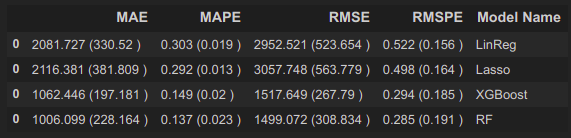

# 8.0 - HYPERPARAMETER FINE TUNING

> Iremos utilizar o **XGBoost** como modelo que será feito o fine tuning

In [14]:
training = X_train[cols_selected_boruta_extended]
training['date'].max()

Timestamp('2015-06-18 00:00:00')

## 8.1 - Random Search

In [53]:
params = {
    "n_estimators": [1000, 500],
    "eta": [0.03, 0.04],
    "max_depth": [15],
    "subsample": [0.7],
    "colsample_bytree": [0.7],
    "min_child_weight": [1, 3]
}
MAX_EVAL = 8

In [54]:
final_result = pd.DataFrame()
model_list = []

from random import sample

previous_params = {}

for i in range(MAX_EVAL):
    
    hp = {k: sample(v, 1)[0] for k, v in params.items()}
    
    if hp == previous_params:
        continue
        
    print(i, ":", hp)

    # model runing on GPU
    model_xgb = XGBRegressor(objective="reg:squarederror",
                             n_jobs=-1,
                             gpu_id=0,
                             tree_method="gpu_hist",
                             **hp)
    model_list.append(model_xgb)

    # performance
    result = cross_validation_ts(model_xgb, training,
                                 "XGBoost-Reg-{}".format(i), 2)
    final_result = pd.concat([final_result, result])
    display(result)
    # print("size: ", getsizeof(model_xgb)) # retirar
    print("-"*100,"\n\n")
    previous_params = hp.copy()

final_result

0 : {'n_estimators': 1000, 'eta': 0.04, 'max_depth': 15, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 1}


KeyboardInterrupt: 

In [41]:
model_list[8]

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.03, gamma=0,
             gpu_id=0, importance_type='gain', interaction_constraints='',
             learning_rate=0.0299999993, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

## 8.2 - Final Model

In [51]:
# Obter o modelo com os melhores parametros

# indice do modelo com menor RMSE
idx_best_model = final_result['RMSE'].apply(
    lambda x: float(x.split(" ")[0])).argmin()

# obtendo melhor modelo da lista de modelos
best_model = model_list[idx_best_model]
idx_best_model, best_model

(2,
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.04, gamma=0,
              gpu_id=0, importance_type='gain', interaction_constraints='',
              learning_rate=0.0399999991, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=4000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None))

In [57]:
# training
# # ** descomentar esse código p/ utilizar parametros diferentes do encontrado(utilizado para trade-off entre memoria e menor erro)**
# param_tuned = {
#     'n_estimators': 3000,
#     'eta': 0.03,
#     'max_depth': 5,
#     'subsample': 0.7,
#     'colsget_xgb_paramsample_bytree': 0.7,
#     'min_child_weight': 3 
# }

param_tuned = {'n_estimators': 2500, 'eta': 0.1, 'max_depth': 7, 'subsample': 0.85, 'colsample_bytree': 0.9, 'min_child_weight': 3}

## Para o modelo em produção colocar predictor="cpu_predictor" se server não possuir GPU. Ainda reduz a memoria alocada
# param_tuned = best_model.get_xgb_params()
param_tuned.update(dict(objective="reg:squarederror", n_jobs=-1, tree_method="gpu_hist",
                          predictor="cpu_predictor"))

best_model = XGBRegressor(**param_tuned)
model_xgb_tuned = best_model.fit(x_train, y_train)

# # predict
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# final result
result = ml_error("XGBoost-Reg final", np.expm1(y_test),
                  np.expm1(yhat_xgb_tuned))
result

,Model Name,MAE,MAPE,RMSE,RMSPE,MPE
0,XGBoost-Reg final,653.239983,0.095143,942.189462,0.126562,0.007035


In [58]:
# # saving model
joblib.dump(model_xgb_tuned, "models/XGBoost_ciclo1_final_3.pkl") # 1º best, but does'nt fit in server 
# joblib.dump(model_xgb_tuned, "models/XGBoost_ciclo1_final_2.pkl") # 2º best (**testar)
# joblib.dump(model_xgb_tuned, "models/XGBoost_cpu_predict.pkl") # worst, but fit in server

# # loading model
# model_xgb_tuned = joblib.load("models/XGBoost_ciclo1_final.pkl") 

['models/XGBoost_ciclo1_final_3.pkl']

# 9.0 - INTERPRETAÇÃO E TRADUÇÃO DO ERRO

In [53]:
df9 = X_test[cols_selected_boruta_extended]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

### (Rascunhos)

In [32]:
y_real = np.expm1(y_test)
y_range = y_real.max() - y_real.min()
y_mean = y_real.mean()
MAE = result['MAE'][0]
MAPE = result['MAPE'][0]
RMSE = result['RMSE'][0]
RMSPE = result['RMSPE'][0]
MPE = result['MPE'][0]

In [48]:
# relação do MAE com a média e o valor do MAPE (bem próximos)
# Ou seja: o MAE é o valor absoluto e o MAPE é o quanto esse valor representa em %
print("MAE/média={:.4%} | MAPE={:.4%}".format(MAE / y_mean, MAPE))

print()
# relação do RMSE com a média e o valor do RMSPE
print("RMSE/média={:.4%} | RMSPE={:.4%}".format(RMSE / y_mean, RMSPE))

MAE/média=9.0734% | MAPE=9.2014%

RMSE/média=13.2144% | RMSPE=12.3233%


## 9.1 - Business Performance

In [98]:
# sum of predictions (pois, o problema é encontrar a previsão para cada loja)
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE, MAPE e MPE para cada uma das lojas
df9_aux1 = (df9[['store', 'predictions', 'sales'
                 ]].groupby('store').apply(lambda row: mean_absolute_error(
                     row['sales'], row['predictions'])).reset_index().rename(
                         columns={0: 'MAE'}))

df9_aux2 = (df9[[
    'store', 'predictions', 'sales'
]].groupby('store').apply(lambda row: mean_absolute_percentage_error(
    row['sales'], row['predictions'])).reset_index().rename(
        columns={0: 'MAPE'}))

df9_aux3 = (df9[['store', 'predictions', 'sales'
                 ]].groupby('store').apply(lambda row: mean_percentage_error(
                     row['sales'], row['predictions'])).reset_index().rename(
                         columns={0: 'MPE'}))

# merge
df9_aux4 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df9_aux4 = pd.merge(df9_aux4, df9_aux3, how='inner', on='store')

# possui os valores de previsões de cada loja do total de receita em 6 semanas.
# Também inclui os erros MAE, MAPE e MPE
df9_2 = pd.merge(df9_1, df9_aux4, how='inner', on='store')

# Scenarios (piores e melhores cenários)
df9_2['worst_scenario'] = df9_2['predictions'].values - df9_2['MAE'].values
df9_2['best_scenario'] = df9_2['predictions'].values + df9_2['MAE'].values

# order columns
df9_2 = df9_2.iloc[:, [0, 1, 5, 6, 2, 3, 4]]
df9_2.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE,MPE
1081,1082,233650.531250,233158.975375,234142.087125,491.555875,0.074146,0.026876
847,848,246988.781250,246121.113836,247856.448664,867.667414,0.118796,0.017037
1070,1071,220063.109375,219656.577465,220469.641285,406.531910,0.068253,0.005223
455,456,222686.296875,222160.319626,223212.274124,525.977249,0.098500,-0.056573
1,2,176534.484375,176215.054133,176853.914617,319.430242,0.066684,0.027564


In [103]:
# lojas mais dificeis de fazer previsão:

df9_2.sort_values('MAPE', ascending=False).head()
# Para essas lojas que performaram muito ruim é necessário avalia-las individualmente no proximo ciclo do CRISP

,store,predictions,worst_scenario,best_scenario,MAE,MAPE,MPE
291,292,104521.109375,101227.916157,107814.302593,3293.193218,0.540132,-0.285253
908,909,241302.859375,233913.409986,248692.308764,7389.449389,0.507589,0.085388
875,876,204960.203125,201120.248726,208800.157524,3839.954399,0.280999,0.038895
594,595,389211.250000,385384.987767,393037.512233,3826.262233,0.264801,0.261469
549,550,239950.015625,238663.609916,241236.421334,1286.405709,0.254221,-0.254221


Text(0.5, 1.0, 'MAPE por Loja')

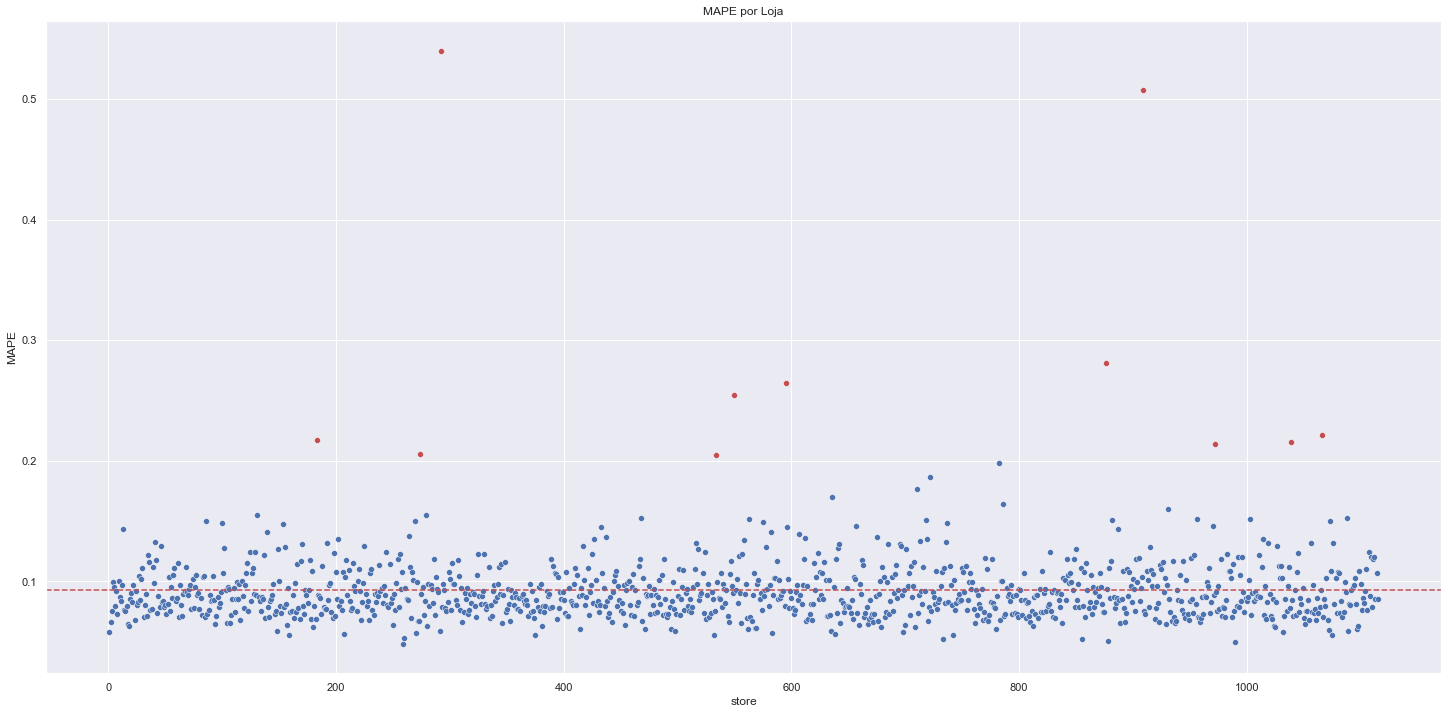

In [115]:
sns.scatterplot(x='store', y='MAPE', data=df9_2.query('MAPE < 0.2'))
sns.scatterplot(x='store',
                y='MAPE',
                data=df9_2.query('MAPE >= 0.2'),
                color='r')

plt.axhline(y=df9_2['MAPE'].mean(), linestyle='--', color='r')

plt.title("MAPE por Loja")

In [104]:
# Lojas mais faceis de fazer previsão:

df9_2.sort_values('MAPE', ascending=True).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE,MPE
258,259,555144.18750,554539.624546,555748.750454,604.562954,0.048315,-0.019706
989,990,229738.28125,229418.277383,230058.285117,320.003867,0.049949,0.028102
877,878,306339.31250,305932.168483,306746.456517,407.144017,0.050216,0.006321
732,733,646402.43750,645662.498410,647142.376590,739.939090,0.051827,-0.026753
854,855,221164.25000,220837.008248,221491.491752,327.241752,0.052447,0.013138


## 9.2 - Total Performance

In [125]:
df9_2[['predictions', 'worst_scenario',
       'best_scenario']].sum().map("€{:,.2f}".format).to_frame().T

,predictions,worst_scenario,best_scenario
0,"€283,703,968.00","€282,992,195.39","€284,415,763.22"


## 9.3 - Machine Learning Performance

In [127]:
df9['error'] = df9['sales'].values - df9['predictions'].values
df9['error_rate'] = df9['predictions'].values / df9['sales'].values

#### comparando as vendas e as predições ao longo do tempo para **todas as lojas**

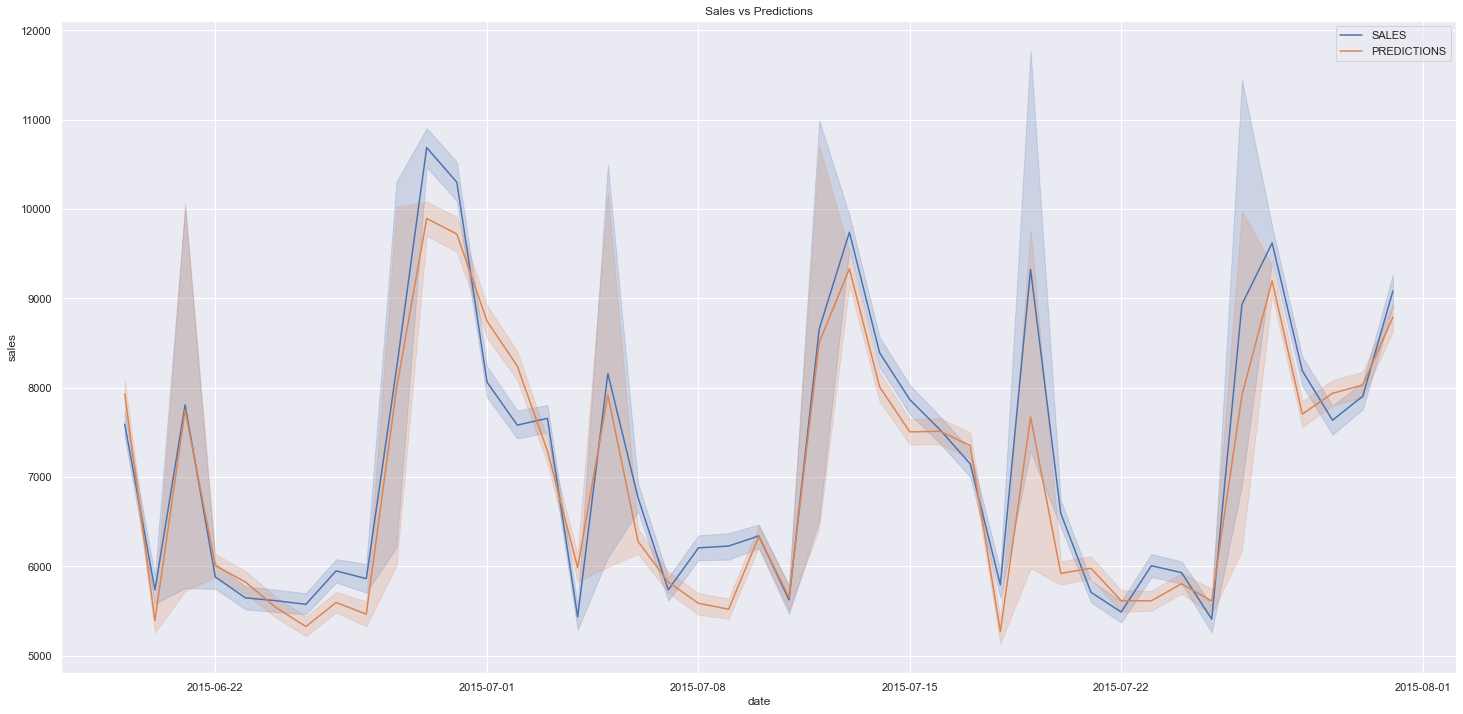

In [130]:
sns.lineplot(x='date', y='sales', data=df9, label="SALES")
sns.lineplot(x='date', y='predictions', data=df9, label="PREDICTIONS")
plt.title('Sales vs Predictions')
plt.show()

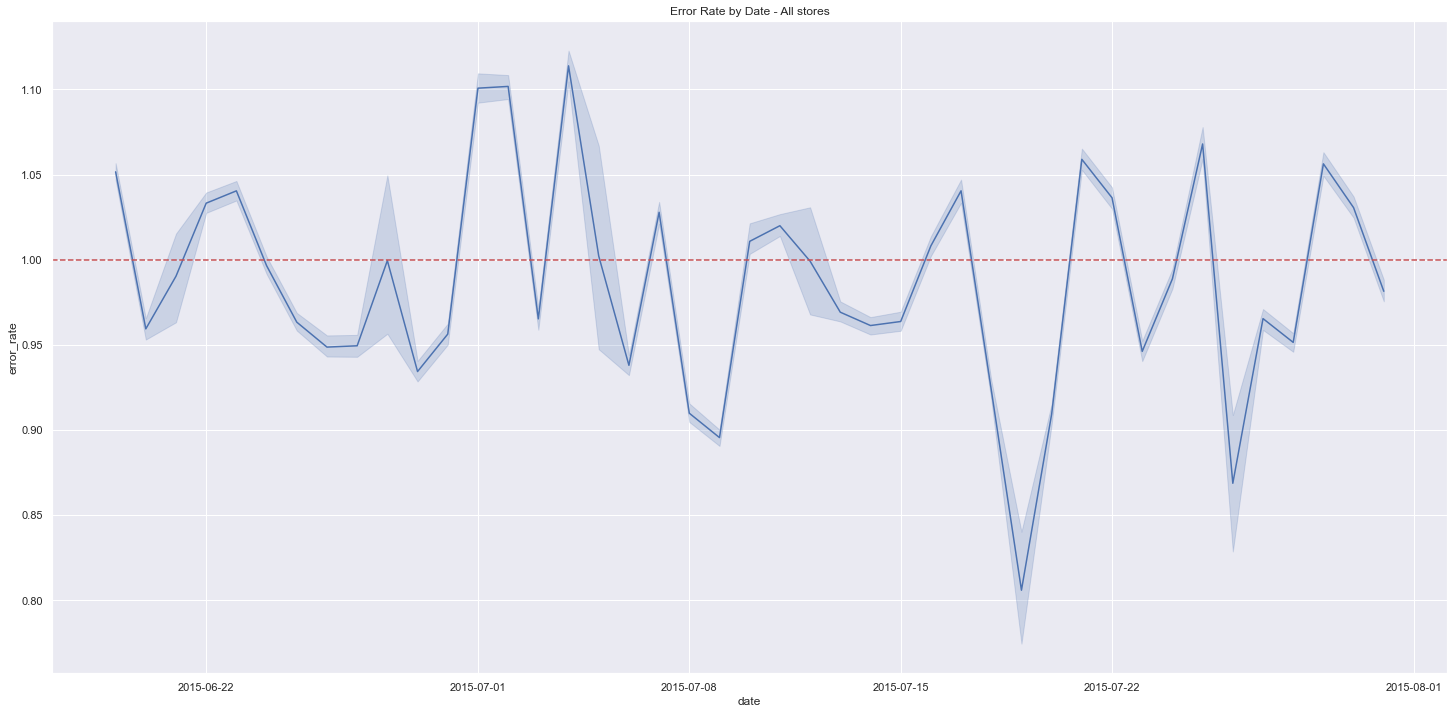

In [157]:
sns.lineplot(x='date', y='error_rate', data=df9)
plt.title('Error Rate by Date - All stores')
plt.axhline(1, linestyle='--', color='r')
plt.show()

#### comparando as vendas e as predições ao longo do tempo da loja com previsão MAIS assertiva

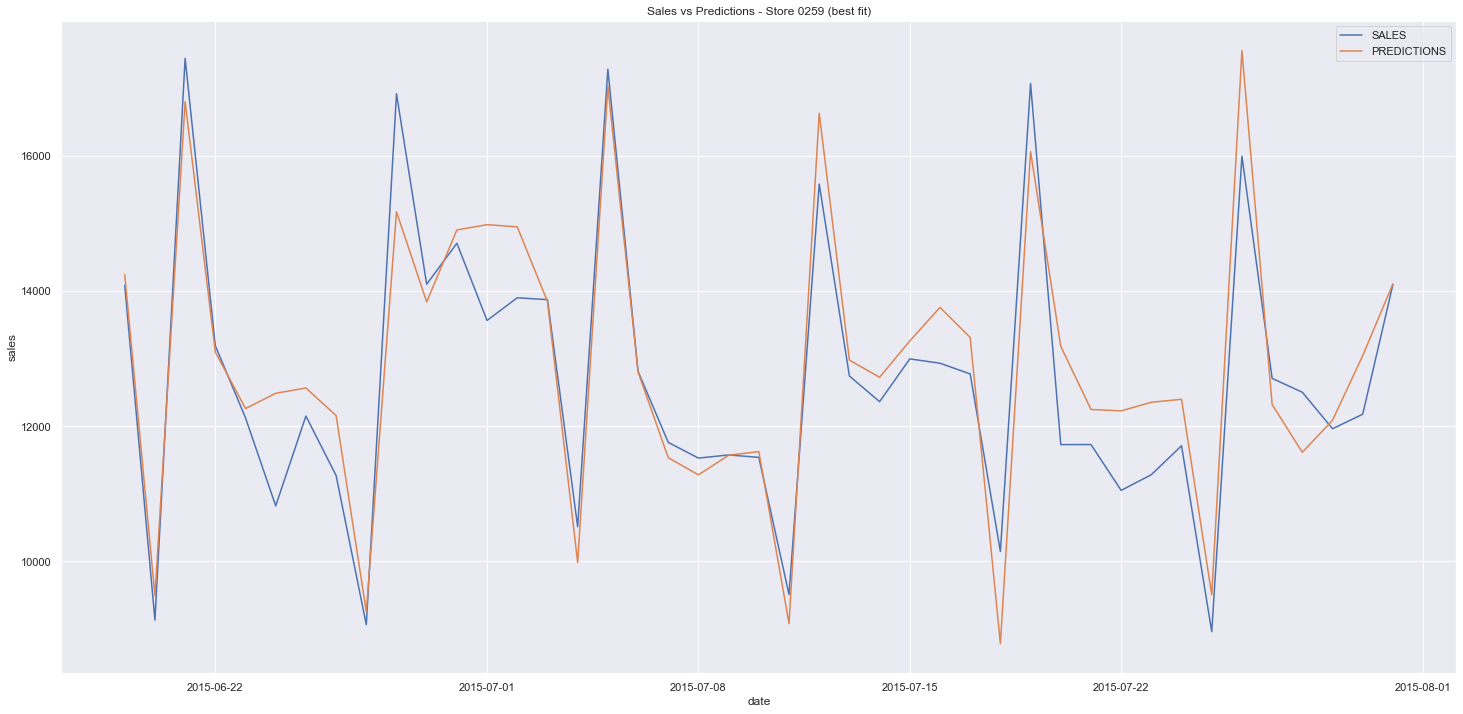

In [136]:
sns.lineplot(x='date',
             y='sales',
             data=df9.query('store == 259'),
             label="SALES",
             markers='.')
sns.lineplot(x='date',
             y='predictions',
             data=df9.query('store == 259'),
             label="PREDICTIONS")
plt.title('Sales vs Predictions - Store 0259 (best fit)')
plt.show()

#### comparando as vendas e as predições ao longo do tempo da loja com previsão MENOS assertiva

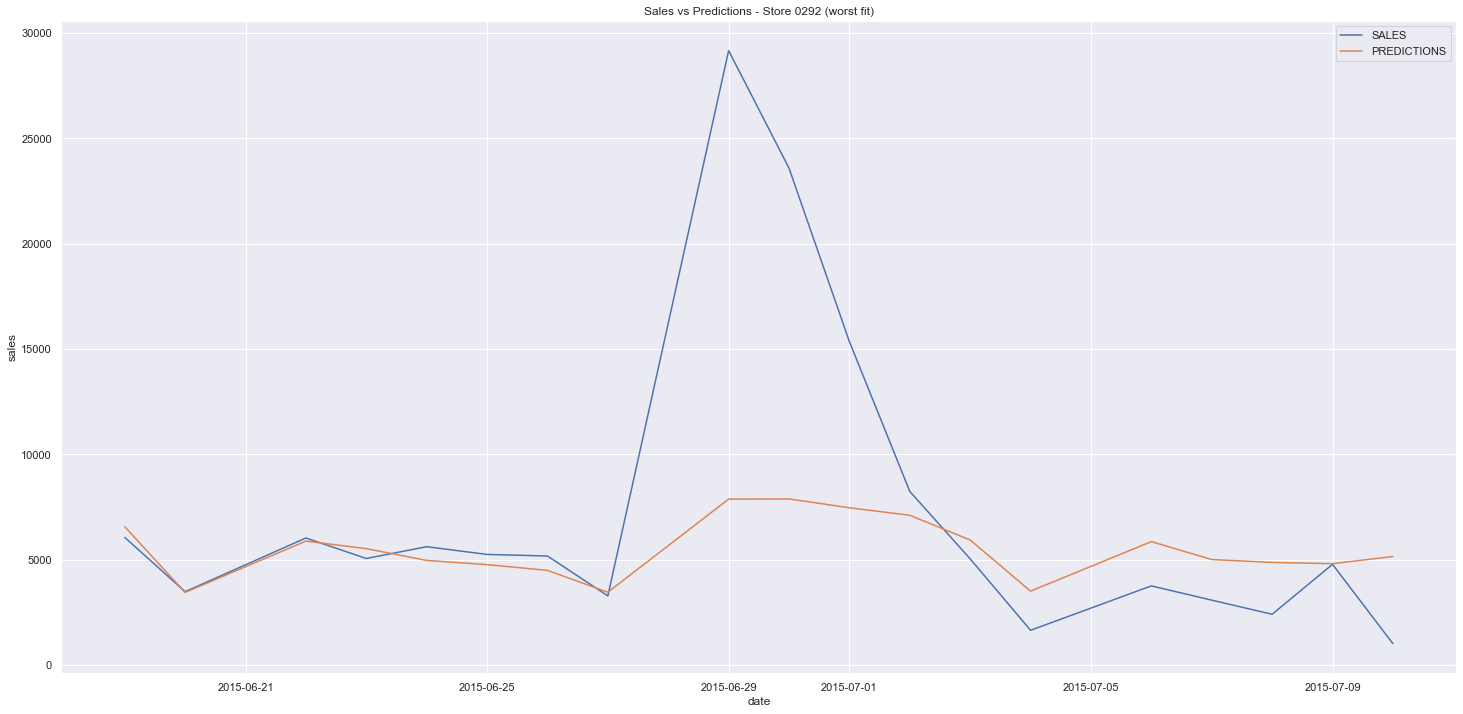

In [142]:
sns.lineplot(x='date',
             y='sales',
             data=df9.query('store == 292'),
             label="SALES")
sns.lineplot(x='date',
             y='predictions',
             data=df9.query('store == 292'),
             label="PREDICTIONS")
plt.title('Sales vs Predictions - Store 0292 (worst fit)')
plt.show()

#### Distribuição do erro (análise de resíduos)

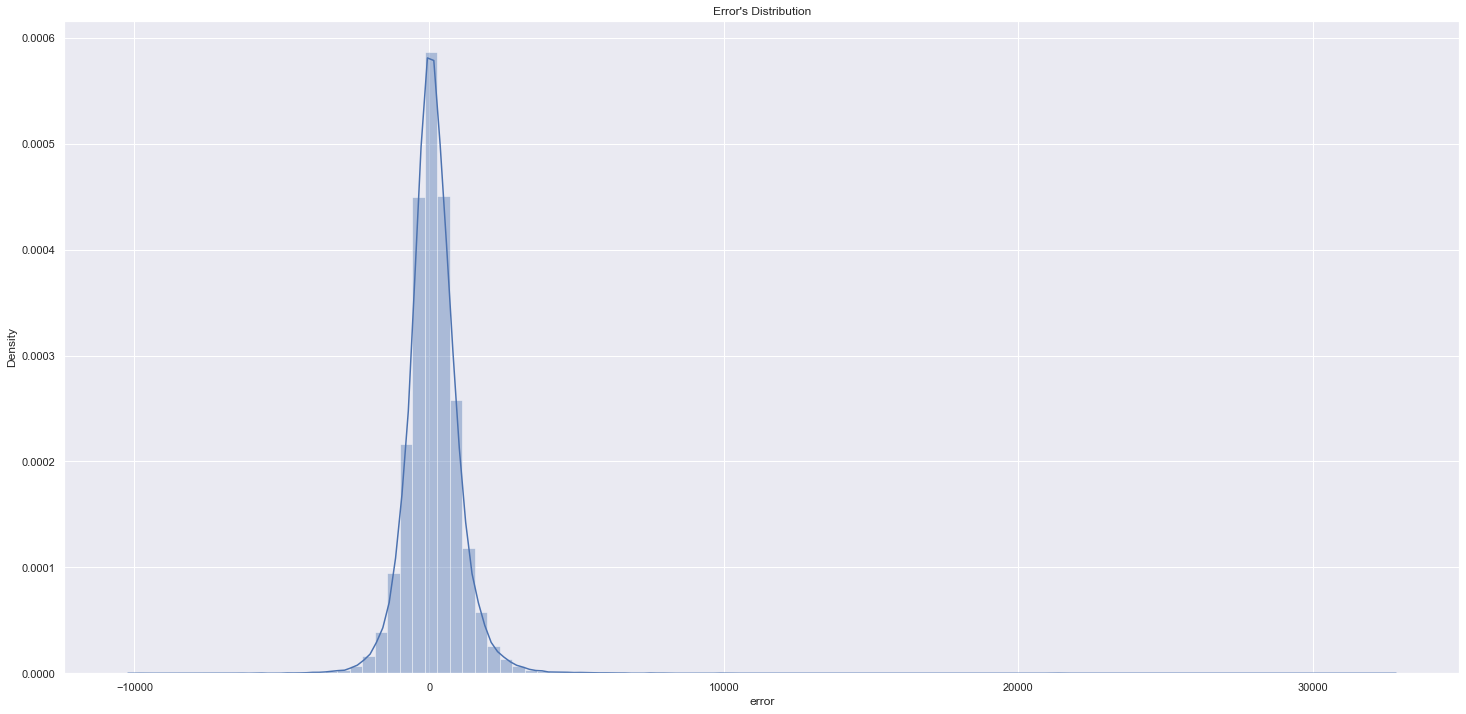

In [154]:
# Quanto mais proximo de uma normal, melhor

sns.distplot(df9['error'], bins=100)
plt.title('Error\'s Distribution')
plt.show()

#### Predictions vs Error (análise de resíduos)

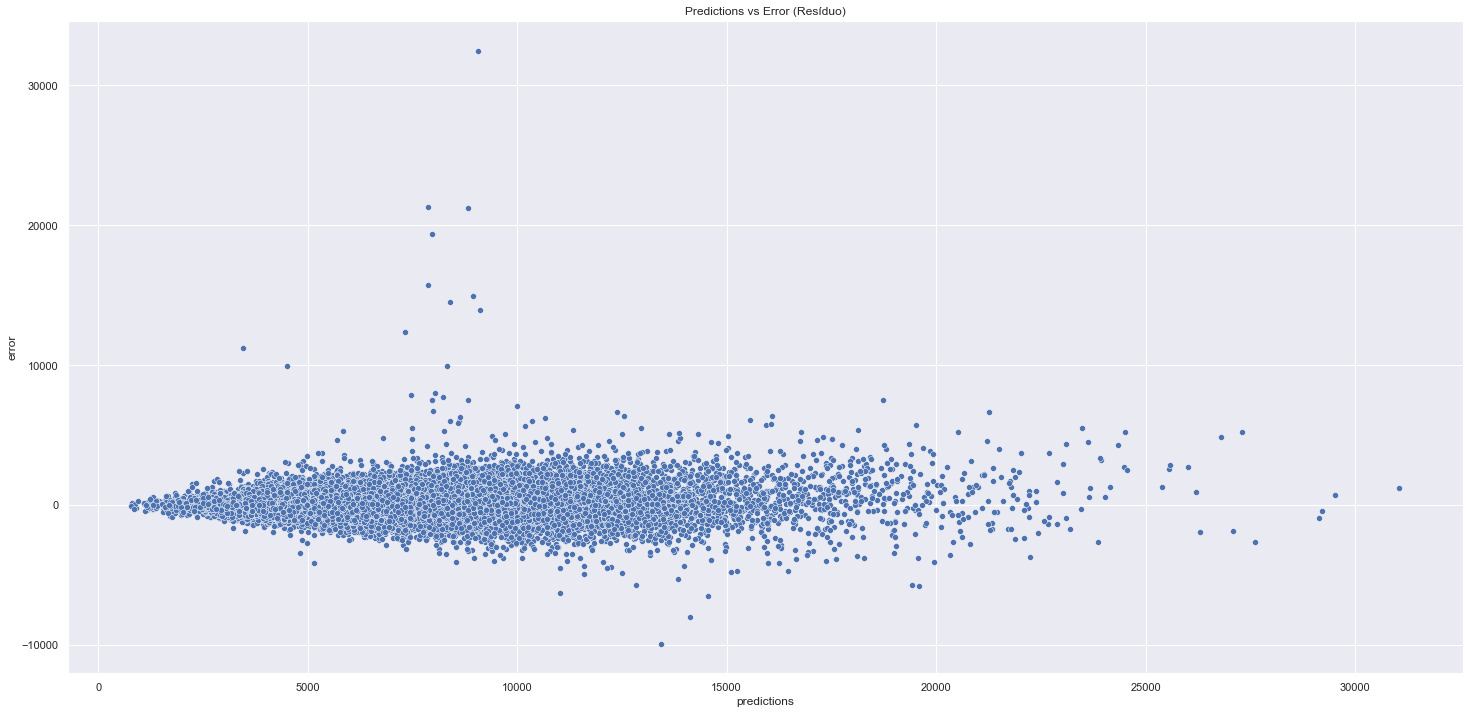

In [158]:
# Quanto mais limitado por um tubo (imaginário), melhor

sns.scatterplot(df9['predictions'], df9['error'])
plt.title('Predictions vs Error (Resíduo)')
plt.show()

# 10.0 - DEPLOY MODEL TO PRODUCTION


> TODO: Depois de finalizado o projeto, colocar todas as transformações, limpezas e encodings em Pipelines do sklean.

> (?) Dentro do método data_preparation as transformações carregadas não deveriam ser aplicadas com .transform ao inves de .fit_transform ? (para manter os mesmos parâmetros do conjunto de treino?)
    > SIM. Tenho que trocar a estratégia para evitar Data Leakage (indicado tbm pelo Meigarom em uma live)

> (?) As transformações dos dados de teste (splitado do dataset de treino) não deveriam ser aplicadas separadas do conjunto de treino? Nesse projeto foram feitas as transformações e depois splitado o conjunto. 

> (?) As predições do cj de teste real não deveriam ser apenas para 42 dias (6 semanas) ? O cj de teste possui 47 dias de dados

In [25]:
# possui 47 dias ao inves de 42 :?
range_days_test = (dt.datetime.strptime("2015-09-17", "%Y-%m-%d") - dt.datetime.strptime("2015-08-01", "%Y-%m-%d"))
range_days_test

datetime.timedelta(days=47)

In [11]:
# # loading model
model_xgb_tuned = joblib.load("models/XGBoost_ciclo1_final_2.pkl")
# model_xgb_tuned = joblib.load("models/XGBoost_ciclo1_final.pkl.bz2")


## 10.1 - Rossmann class


> Movido para o arquivo [Rossmann.py](file:///home/patrick/PycharmProjects/ds_em_producao/Rossmann.py)

## 10.2 - API Handler

> Movido para o arquivo [handler.py](file:///home/patrick/PycharmProjects/ds_em_producao/api/handler.py)

## 10.3 - API Tester

> Copiado e modificado no arquivo [rossmann-telegram-api/rossmann-bot.py](#)

In [12]:
import json
import requests

In [13]:
# loading test dataset
df_test_raw = pd.read_csv("data/test.csv")
df_store_raw = pd.read_csv("data/store.csv")

In [14]:
# merge test + store
df_test = pd.merge(df_test_raw, df_store_raw, on="Store", how="left")

In [43]:
# choose store for prediction
def df_test_stores(stores):
    df1 = df_test.query("Store in @stores")

    df1 = df1[(df1["Open"] != 0) & (~df1["Open"].isnull())]

    df1#.drop("Id", axis=1, inplace=True)
    return df1

def df_test_all():
    df1 = df_test[(df_test["Open"] != 0) & (~df_test["Open"].isnull())]

    df1#.drop("Id", axis=1, inplace=True) # precisa do ID pra sumbissão no kaggle
    return df1

In [44]:
# stores_data = json.dumps(df_test_stores([1]).to_dict(orient="records")) # orientação == records (cada registro == um dict)

all_data = json.dumps(df_test_all().to_dict(orient="records"))

In [96]:
# API call
endpoint = "http://rossmann-sales-predictions.herokuapp.com/"
url = endpoint + "rossmann/predict"
header = {"Content-type": "application/json"}
# data = all_data
# data = stores_data
preds = []
for x in range(10):
    stores = df_test.Store.unique()[x::10]
    data = json.dumps(df_test_stores(stores).to_dict(orient="records"))
    r = requests.post(url, data=data, headers=header)
    print(x, "Status code {}".format(r.status_code))
    preds += [pd.DataFrame(r.json())[["Store","Date", "prediction"]]]

0 Status code 200
1 Status code 200
2 Status code 200
3 Status code 200
4 Status code 200
5 Status code 200
6 Status code 200
7 Status code 200
8 Status code 200
9 Status code 200


In [74]:
# r = requests.get(endpoint+"change_model_2")
# print("Status code {}".format(r.status_code))

Status code 503


In [87]:
# # predicões
# pred = pd.DataFrame(r.json())
# pred[["Store","Date", "prediction"]].head(5)

,Store,Date,prediction
0,1,2015-09-17,4481.597656
1,29,2015-09-17,7244.334473
2,52,2015-09-17,6887.708008
3,79,2015-09-17,4867.473633
4,108,2015-09-17,9821.533203


In [205]:
#juntando todas as requisições (apenas para todos os dados de teste)
pred = pd.concat(preds, axis=0)
pred.shape

(35093, 3)

In [206]:
to_put = df_test[(df_test.Open == 0) | (np.isnan(df_test.Open))]
to_put["prediction"] = 0

In [121]:
pred_ = pd.concat([pred, to_put[["Store","Date", "prediction"]]], axis=0)

In [223]:
# gerando resultados para submeter no kaggle
df_result = pd.merge(df_test, pred_[["prediction", "Store", "Date"]], how="inner", on=["Store", "Date"])


df_result = df_result[["Id", "prediction"]].rename({"prediction":"Sales"}, axis=1)
df_result.set_index("Id").to_csv("my_first_submission.csv")

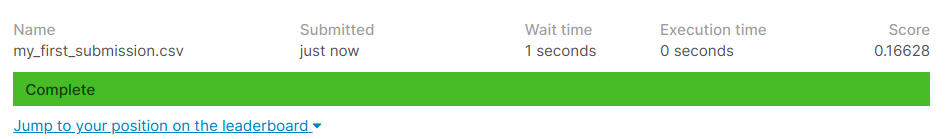

Obs: Submissão dos resultados do modelo em produção (pior modelo)

In [66]:
# Vendas Totais das proximas 6 semanas
sum_by_store = pred[["Store", "prediction"]].groupby("Store").sum().reset_index()

for _, row in sum_by_store.iterrows():
# for _, row in sum_by_store.sample(5).iterrows():
    print("A loja {} venderá €{:,.2f} nas proximas 6 semanas.".format(row["Store"].astype(int), row["prediction"]))

A loja 1 venderá €182,337.83 nas proximas 6 semanas.
A loja 22 venderá €194,274.48 nas proximas 6 semanas.


# Extra: Medindo tempo de processamento do notebook

In [ ]:
time_end = time.perf_counter()
print("Tempo para processamento do notebook completo:", time_end - time_ini,
      "sec")